# S&P 2019 Data Exploration Stage

**by Marc Angelo Acebedo**

# Table of Contents
- [Introduction](#introduction)
- [Data Setup & Overview](#setup)
- [Preliminary Wrangling](#prelim)
- [Exploration](#explore)
    - [Univariate](#uni)
    - [Bivariate](#bi)
    - [Multivariate](#multi)
- [Conclusions](#conclude)

# I) Introduction <a id = "introduction"> </a>


- I kept features in separate CSVs because date formats differ. `eps_fc` and `eps_act` 

### After cleaning the original dataset as documented in my data wrangling process [here](TK) tk, I isolated the following columns:

### `features.csv`
- **firm_id** : foreign key referring to primary keys in `firms.csv`
- **feature** : type of feature that the **value** field denotes (eps_fc, eps_act, eod_act, eps_fc_terms) 
- **date**    : DateTime object in YYYY-MM-DD format 
    - for **eod_act**, means the date at which the value was recorded
    - for **eps_fc_terms**, means the date at which the term forecast was made
- **term** :  period object in YYYYQQ format (the time period when the value was recorded)
    - FISCAL years for eps_fc, eps_act, and eps_fc_terms
    - CALENDAR years for eod_act
- **value** : displays the EPS or EOD value as specified in the 'feature' column.

### `avgs.csv`
- **firm_id** : foreign key referring to the primary keys in `firms.csv`
- **average** : recorded average value as specified in the `average_type` column
- **average_type** : type of average denoted (twenty year, quarterly, or yearly)
- **time_period** : time period that the average is recorded:
    - for twenty-year averages, it's NaN
    - for yearly averages, displays the year (YYYY)
    - for quarterly averages, displays the quarter (QQ)
- **feature** : type of feature recorded for the average (eps_fc, eps_act, eod_act, eps_fc_terms)

# II) Data Setup & Overview<a id = "setup"></a> 

In [1]:
#import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import statsmodels.api as sm
import math 
import random
import calendar

from matplotlib import cm

%matplotlib inline
plt.style.use('bmh')

In [2]:
#define data directories
PATH_CLEAN = './data/clean/'
PATH_CLEAN_AVGS = './data/clean/averages/'

In [3]:
#define visuals destination
PATH_UNIVARIATE = './visuals/univariate/'
PATH_BIVARIATE = './visuals/bivariate/'
PATH_MULTIVARIATE = './visuals/multivariate/'

**Import features and all averages**

In [4]:
features = pd.read_csv(PATH_CLEAN + 'features.csv', low_memory = False)
avgs = pd.read_csv(PATH_CLEAN_AVGS + 'avgs.csv')

In [5]:
#import firm_ids for foreign key references
firm_ids = pd.read_csv(PATH_CLEAN + 'firms.csv')

### Describe Datasets

In [6]:
#look at 5 random entries
features.sample(5)

,firm_id,feature,date,term,value
3071,36,eod_act,2010-12-31,2010Q4,54.900
131827,78,eps_act,NaN,2007Q4,1.040
159186,404,eps_act,NaN,2001Q3,0.045
7614,90,eod_act,2012-09-28,2012Q3,NaN
86199,40,eps_fc,NaN,2003Q4,NaN


In [7]:
avgs.sample(5)

,firm_id,average,average_type,time_period,feature
27251,486,NaN,yearly,2006,eod_act
32555,235,34.317500,yearly,2017,eod_act
864,359,0.328423,twenty_year,NaN,eps_act
25192,447,12.710000,yearly,2002,eod_act
37711,341,0.366000,yearly,2007,eps_fc_terms


In [8]:
print('FEATURES rows, columns = {}'.format(features.shape), '\n',
      'AVERAGES rows, columns = {}'.format(avgs.shape))

FEATURES rows, columns = (167660, 5) 
 AVERAGES rows, columns = (52015, 5)


### Convert DateTime columns

In [9]:
features.dtypes

firm_id      int64
feature     object
date        object
term        object
value      float64
dtype: object

In [10]:
features.date = pd.to_datetime(features.date)
features.term = pd.to_datetime(features.term).dt.to_period('Q')

In [11]:
#verify dtypes
features.dtypes

firm_id             int64
feature            object
date       datetime64[ns]
term        period[Q-DEC]
value             float64
dtype: object

In [12]:
avgs.dtypes

firm_id           int64
average         float64
average_type     object
time_period      object
feature          object
dtype: object

In [13]:
features.sample(5)

,firm_id,feature,date,term,value
153719,339,eps_act,NaT,1999Q4,0.2800
71589,364,eps_fc_terms,2012-01-01,2012Q2,0.8400
130375,61,eps_act,NaT,2001Q4,-0.1300
154762,351,eps_act,NaT,2008Q3,0.4200
25622,305,eod_act,1999-09-30,1999Q3,27.2456


# III) Preliminary Wrangling <a id = "prelim"></a>

### Structure of the Datasets
> Our `features.csv` dataset contains 167,660 entries with 5 features. Firm ID, feature, date, and term are all categorical variables while the value field is numeric and continuous. Even though the date and term fields are recorded as DateTime and Period objects respectively, they are still discrete, categorical data, because there is a limit to the year that can be recorded (1999 - 2020) and there cannot be more than 4 quarters (Q1 - Q5).

> Our `avgs.csv` dataset contains 52,015 entries with 5 features. Firm ID, average type, time period, and feature are all categorical variables while the average field is numeric and continuous. 


### Main features(s) of interest in the dataset

> I'm interested in seeing the ***historical correlation of forecasted vs. actual EPS across all firms in the 2019 S&P Index.***

- **eps_fc**, **eps_act** are the main variables of interest—they are consistent in measuring both the *forecasted* and *actual* EPS of all 505 firms, per fiscal period, over a span of 20 years.
- **eod_act** is recorded based on ***calendar period*** instead of fiscal period, which is a flaw in the data. However, it can be used for some further exploration.
- **eps_fc_terms** is based on ***fiscal period***. Although it depicts forecasted EPS, this is still not a main variable of interest because it can *extend* my main research question, but not fully answer it.

> As somebody with very little familiarity with the stock market, I decided to dabble a little in the stock market. I read the book "A Beginner's Guide to the Stock Market" by Matthew R. Kratter, which piqued my interest in stock market trading—particularly dividend stocks. I decided that if I were going to educate myself further on the stock market, then this thesis project to end my senior year at NCF would be a perfect opportunity to directly explore this new interest. Not only would I be educating myself on how the stock market works, but I would also be *working directly with stock market data*, which will help me build further intuition in future stock market and finance-related projects.

These are the questions I'd like to pose in my exploratory stage:

- What is the difference in means between average forecasted and actual EPS of each firm for the past 20 years?
- What is the relationship between forecasted EPS for both forecasts made at the beginning of the fiscal period and three months prior?
- Does historical EOD price correlate with forecasted EPS? How about actual EPS?
- For both the highest-performing and lowest-performing companies, do EPS forecasts show a pessimistic and/or optimistic view of their company value?

### Features in the dataset that will support my investigation into the features of interest

> For the broadest overview, I predict that ***overtime, EPS forecasts will continually become optimistic for those firms that consistently have high actual EPS values. Vice versa, overtime, EPS forecasts will continually become pessimistic for those firms that consistently have lower-than-expected EPS values.*** As for the other factors, I expect yearly values to show more consistency in pattern (since it is more intuitive to measure 20 years) than quarterly values (since economic situations are greatly diverse over the period of 20 years, no matter the period).

- kept **time_period** as an object bc column consists of varying DateTime formats

# IV) Exploration <a id="explore"> </a>

## A) Univariate <a id = "uni"></a>

### MISSING VALUES (Features)

In [14]:
sb.set(style = "darkgrid")

In [15]:
def generate_missing_total(df, title_name, save_path, csv_name):
    plt.figure(figsize = [10, 5])
    plt.title('Missing Values per Column under ' + title_name, size = 20)
    na_counts = df.isna().sum().sort_values(ascending = True)
    
    na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
    plt.xlabel('Count', size = 10)
    plt.ylabel('Column Name', size = 10)
    plt.savefig(save_path + csv_name)

In [16]:
features.isna().any()

firm_id    False
feature    False
date        True
term       False
value       True
dtype: bool

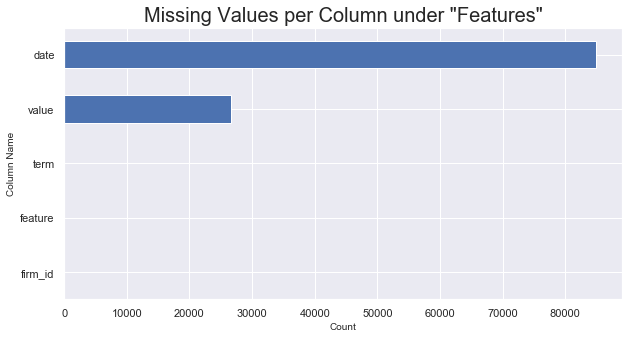

In [17]:
generate_missing_total(features, '"Features"', PATH_UNIVARIATE, 'features-missing-total.png')

**Observation 1:** `date` is the field with the highest amount of missing data, with around **85,000 missing entries.**

**Observation 2:** `value` contains around **26,000 missing entries.***

**Observation 3:** The gap in number of missing values between *value* and *date* is noticeably large.
- This makes sense because *date* is automatically set to 'NaT' for *eps_fc* and *eps_act*.

--- 

**Questions**

1)  For all the entries where *date* is not NaT, how large is the gap in missing values between *values* without the dropped dates and *values* with the dropped dates?

In [18]:
features_date_dropna = features[features['date'].notna()]

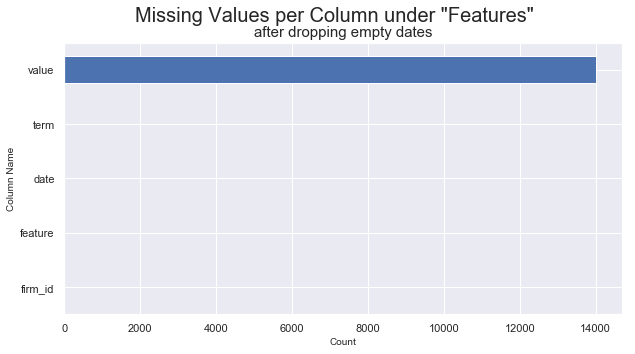

In [19]:
plt.figure(figsize = [10, 5])
plt.suptitle('Missing Values per Column under "Features"', size = 20)
plt.title('after dropping empty dates', size = 15)
na_counts = features_date_dropna.isna().sum().sort_values(ascending = True)

fig = na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
plt.constrained_layout = True
plt.xlabel('Count', size = 10)
plt.ylabel('Column Name', size = 10)
plt.savefig(PATH_UNIVARIATE + 'features-missing-date-dropna.png')

### Question 1: For all the entries where *date* is not NaT, how large is the gap in missing values between *values* without the dropped dates and *values* with the dropped dates?
### Answer

**Observation 1:** Keeping NaT dates, the amount of overall missing values is around **26,000**. After dropping all the NaT dates (dropping `eod_act`and `eps_fc_terms`), the amount of missing values dropped to around **14,000.**

**Observation 2:** Drawing from the previous observation, this means that `eps_fc` and `eps_act` both have around **12,000** missing values in total.

**Observation 3:** Effectively, the undropped columns, `eod_act` and `eps_fc_terms`, have around **14,000** missing values in total.

---

**Questions:**

2) How many missing values does each feature have, individually?

In [20]:
#turn feature values into index values
features_num_nan = features[['feature', 'value']].groupby('feature').count()

In [21]:
#count number of total values (NaN or not) per feature
feature_counts = features.feature.value_counts()

In [22]:
#create function to calculate number NaN
def calculate_nan(num_nan, counts, feature_name):
    num_nan.loc[feature_name] = counts[feature_name] - num_nan.loc[feature_name]
    #num NaN (feature) = num all values (NaN or not) - num all values (not NaN)
    
#create array of feature names
feature_names = ['eps_fc', 'eps_act', 'eod_act', 'eps_fc_terms']

In [23]:
#update all nan counts per average type
for feature_name in feature_names:
    calculate_nan(features_num_nan, feature_counts, feature_name)

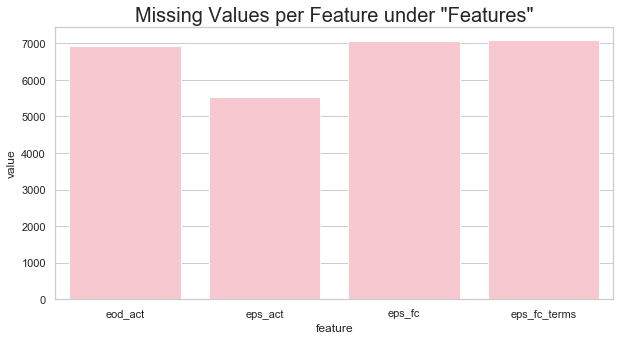

In [24]:
plt.figure(figsize = [10, 5])
sb.set(style = 'whitegrid')
plt.title('Missing Values per Feature under "Features"', size = 20)
plt.xlabel('Feature')
plt.ylabel('Count')

sb.barplot(x = features_num_nan.index, y = features_num_nan.value, color = "pink")
plt.savefig(PATH_UNIVARIATE + 'features-missing-per-feature.png')

**Observation 1:** The feature with the most amount of missing values is `eps_fc_terms`.

**Observation 2:** The feature with the least amount of missing values is `eps_act`.

**Observation 3:** `eod_act`, `eps_fc`, and `eps_fc_terms` all have a very small gap in missing data comparedto `eps_act`

### Question 2: How many missing values does each feature have, individually?

### Answer:

**Observation 1:** Below is a list of each feature and their corresponding estimated number of missing values:

- `eod_act` : 7900
- `eps_act` : 5500
- `eps_fc` : 7050
- `eps_fc_terms` : 7100

**Observation 2:** `eps_fc` and `eps_act` have around 12,000 missing values total, which is consistent with our previous observation.

**Observation 3:** `eod_act` and `eps_fc_terms` have around 14,000 missing values total, which is also consistent with our previous observation.



### MISSING VALUES (Averages)

In [25]:
avgs.isna().any()

firm_id         False
average          True
average_type    False
time_period      True
feature         False
dtype: bool

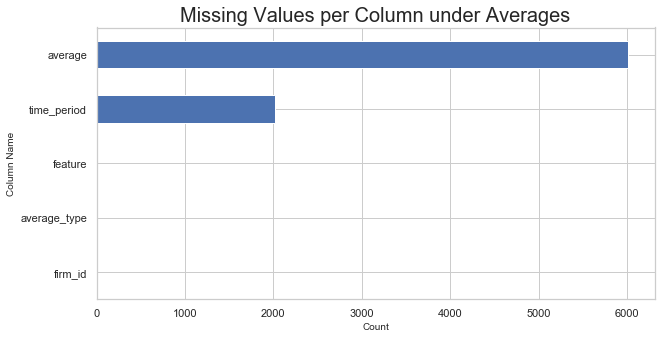

In [26]:
#averages
generate_missing_total(avgs, 'Averages', PATH_UNIVARIATE, 'avgs-missing-total.png')

**Observation 1:** The *average* column contains 6,000 missing data entries.

**Observation 2:** The *time_period* column contains exactly 2,000 missing data entries.

**Observation 3:** The gap in missing values between *average* and *time_period* is 4,000. 

**Observation 3:** By default, all entries with *average_type* of **twenty_year** should have **NaT** fields for *time_period*. 

---

**Questions:**

3) After dropping all NaT fields under *time_period*, how large will the gap in missing values be between *values with the NaT dates* and *values after dropping the NaT dates*?

4) How many missing *average* values does each *average_type* contain?



In [27]:
avgs_date_dropna = avgs[avgs['time_period'].notna()]

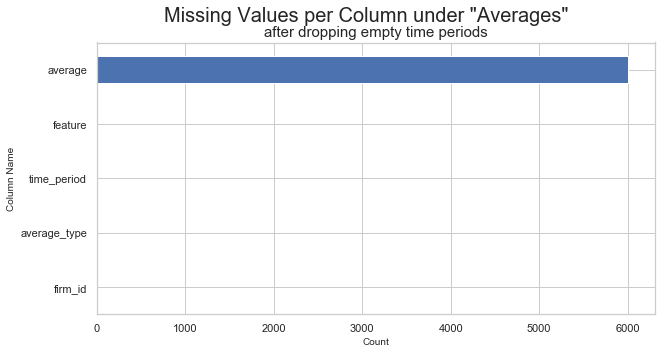

In [28]:
plt.figure(figsize = [10, 5])
plt.suptitle('Missing Values per Column under "Averages"', size = 20)
plt.title('after dropping empty time periods', size = 15)
na_counts = avgs_date_dropna.isna().sum().sort_values(ascending = True)

fig = na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
plt.constrained_layout = True
plt.xlabel('Count', size = 10)
plt.ylabel('Column Name', size = 10)
plt.savefig(PATH_UNIVARIATE + 'avgs-missing-date-dropna.png')

### Question 3:  After dropping all NaT fields under time_period, how large will the gap in missing values be between values with the NaT dates and values after dropping the NaT dates?

### Answer: 
**Observation 1:** After dropping all NaT dates under *time_period*, there are still 6,000 missing *averages*. This is number is consistent with the number of missing *averages* even before dropping NaT dates. Thus, **all entries with a missing time period** (aka all **twenty_year** average types) **did not contain any empty data.**

**To summarize the above, the number of missing *average values* remains the same whether or not you drop all entries with empty time periods, aka all twenty_year average types.**

In [29]:
#turn avg values into index values
avgs_num_nan = avgs[['feature', 'average']].groupby('feature').count()

In [30]:
#count number of total values (NaN or not) per feature
avgs_counts = avgs.feature.value_counts()

In [31]:
#update number of missing values for each average type
for feature_name in feature_names:
    calculate_nan(avgs_num_nan, avgs_counts, feature_name)

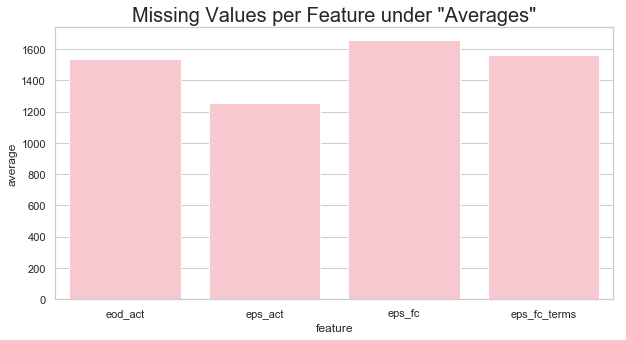

In [32]:
plt.figure(figsize = [10, 5])
# sb.set(style = 'whitegrid')
plt.title('Missing Values per Feature under "Averages"', size = 20)
plt.xlabel('Feature')
plt.ylabel('Count')

sb.barplot(x = avgs_num_nan.index, y = avgs_num_nan.average, color = "pink")
plt.savefig(PATH_UNIVARIATE + 'avgs-missing-per-feature.png')

**Observation 1:** *eps_fc* has the most missing values at around 1650.

**Observation 2:** *eps_act* has the least amount of missing values at around 1250.

**Observation 3:** Under "Averages", the gap in missing values between each average type is ***larger*** than the missing values under "Features".

### Question 4: How many missing average values does each average_type contain?

### Answer:

**Observation 1:** Each average type has the following *approximate* number of ***missing averages***:

- `eod_act` : 1550
- `eps_act` : 1250
- `eps_fc` : 1650
- `eps_fc_terms` : 1590

### FIRM_ID (Features)

> Since 505 firms is too much to fit into one single visual, I decided to split them apart by focusing on the ***20 most common firm ids*** and the ***20 rarest firm ids***.

In [33]:
def generate_pct_bar(df, cat_var, color):
    cat_counts = df[cat_var].value_counts()
    ax = sb.countplot(data = df, y = cat_var, order = cat_counts.index, palette = color)
    
    n_points = df.shape[0]
    locs, labels = plt.yticks()
    
    for p in ax.patches:
        percentage = '{:0.1f}%'.format(100 * p.get_width()/n_points)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), size = 20)

In [34]:
features_firm_id_top = features.firm_id.value_counts()[:20].index
features_firm_id_top_lim = features.loc[features.firm_id.isin(features_firm_id_top)]

#check there are only 50 unique values
features_firm_id_top_lim.firm_id.nunique()

20

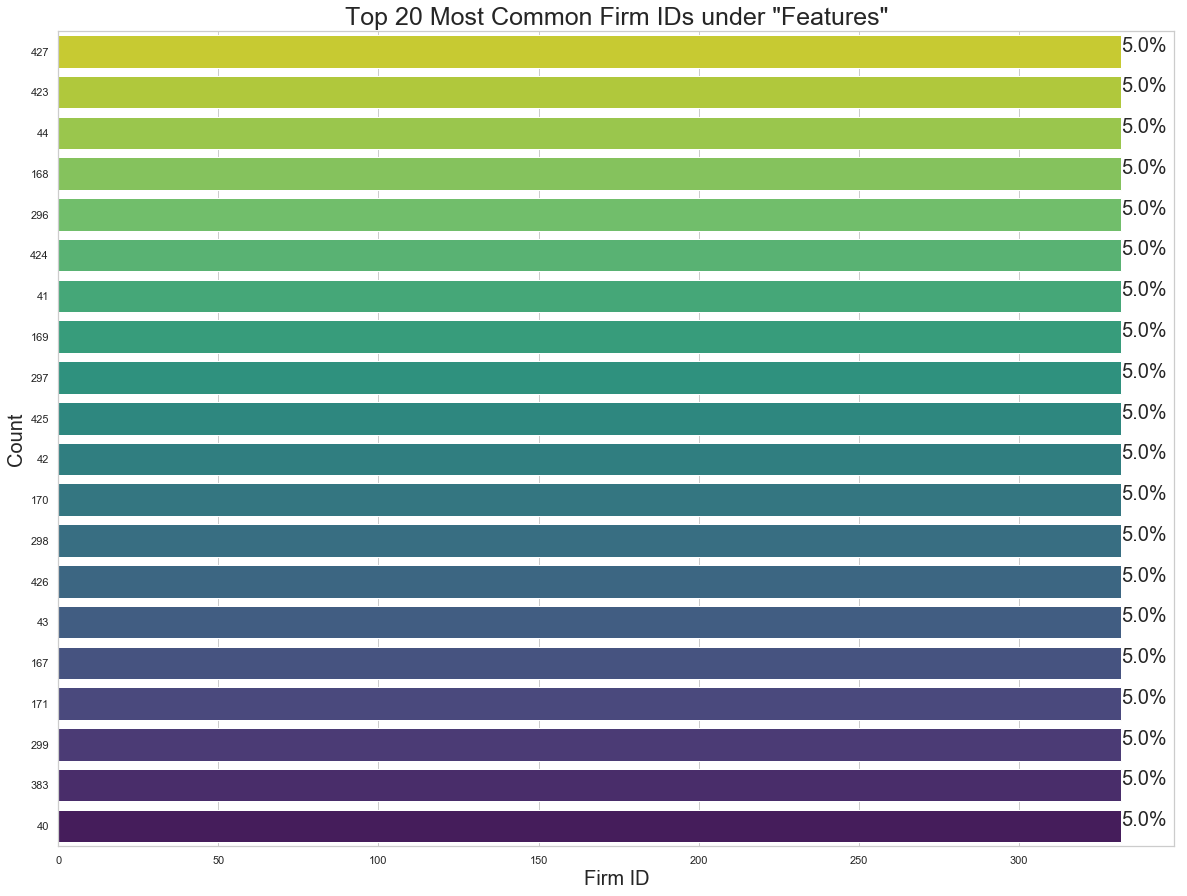

In [35]:
plt.figure(figsize = [20, 15])
x = features_firm_id_top_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('Top 20 Most Common Firm IDs under "Features"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'features-firm-id-count-top.png');
plt.show();

In [36]:
features_firm_id_bottom = features.firm_id.value_counts()[-20:].index
features_firm_id_bottom_lim = features.loc[features.firm_id.isin(features_firm_id_top)]

#check there are only 50 unique values
features_firm_id_bottom_lim.firm_id.nunique()

20

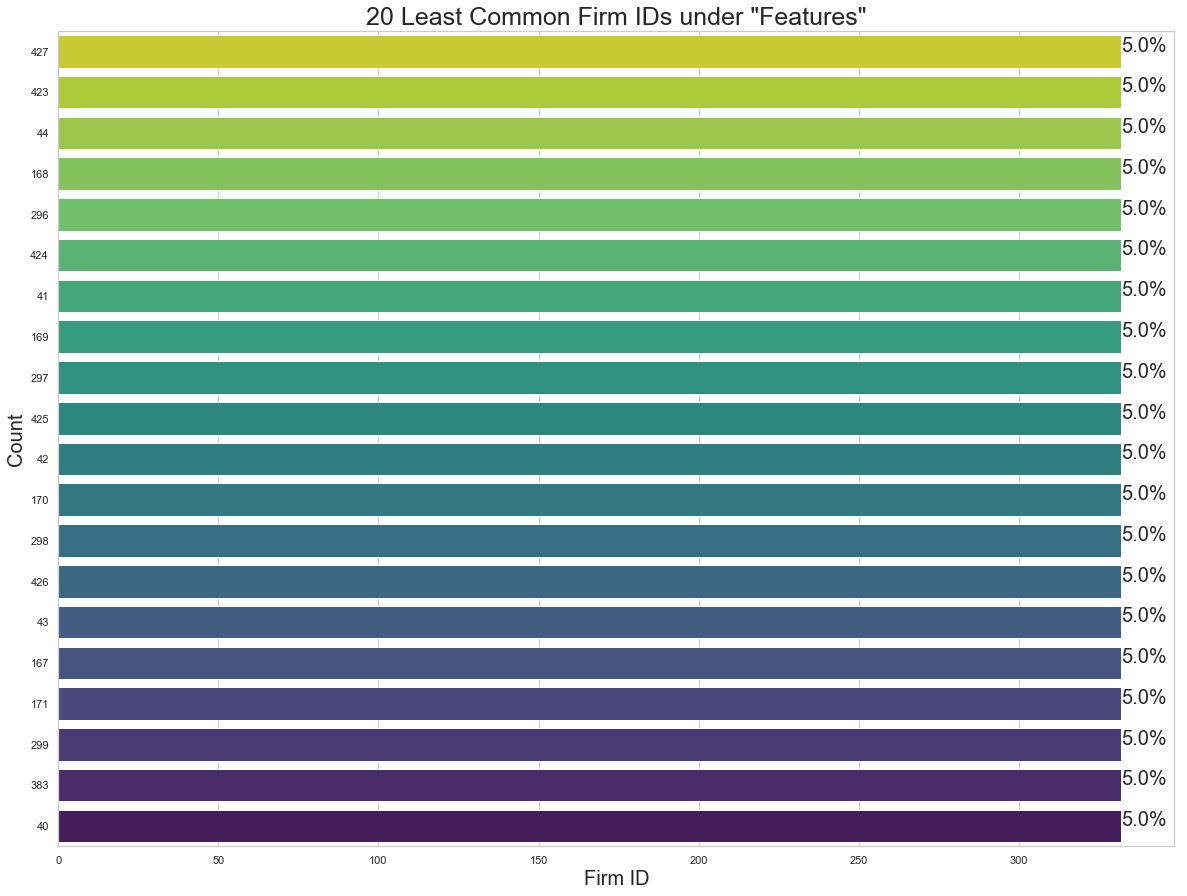

In [37]:
plt.figure(figsize = [20, 15])
x = features_firm_id_bottom_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('20 Least Common Firm IDs under "Features"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'features-firm-id-count-bottom.png');
plt.show();

**Observation 1:** Both the 20 most common and least common Firm IDs all make up the same proportion of existing Firm IDs: 5.0% each. This means that under "Features", there is a **consistent count among all Firm IDs** at around 335.

In [38]:
#check consistency of counts among firm_ids
firm_counts = features.firm_id.value_counts()
np.unique(firm_counts.sort_values().values)

array([332], dtype=int64)

> I discovered that ***all firm id counts are consistent across the entire features.csv dataset*** at 332 entries per firm id. There are no null firm ids.

### FEATURE (Features)

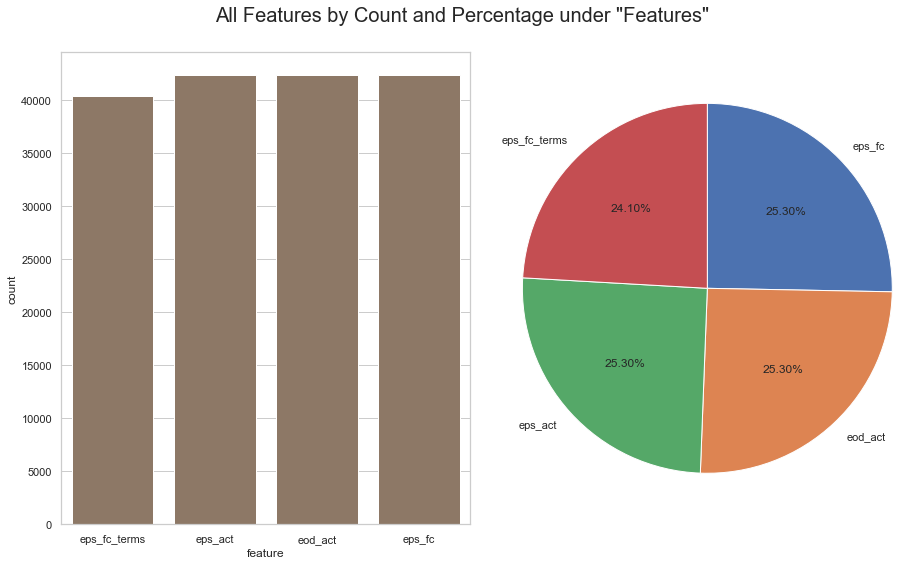

In [39]:
import itertools
plt.figure(figsize = [13, 8])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
sb.countplot(data = features, x = 'feature', order = features.feature.value_counts(ascending = True).index,
            color = base_color)
frame = plt.gca()

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = features['feature'].value_counts()
plt.pie(features.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = features.feature.value_counts().index);
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Features"', size = 20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'features-feature-pct-count.png')


**Observation 1:** `eps_act`, `eps_fc`, and `eod_act` all show consistent counts at around 42500 entries each (25.30% each).

**Observation 2:** `eps_fc_terms` is the only *feature type* to deviate from the others, having less entries at around 405,000 (24.10%).

**Observation 3:** It makes sense that `eps_fc_terms` contains missing data, because ***the year 1999 was not included while gathering this data.*** (effectively removing 2020 entries).

### DATE (Features)

In [40]:
#double check that eps_fc and eps_act are the only features to have null Date entries
features[features.date.isna()].feature.unique()

array(['eps_fc', 'eps_act'], dtype=object)



> Since we acknowledged that the `date` column is set to NaT for `eps_fc` and `eps_act`, we will write all our interpretations accordingly.

### All below graphs under "Date" do not take into account the features `eps_fc` and `eps_act`.

In [41]:
features_years = features.date.dt.year.dropna().astype(int)
features_months = features.date.dt.month.dropna().astype(int)

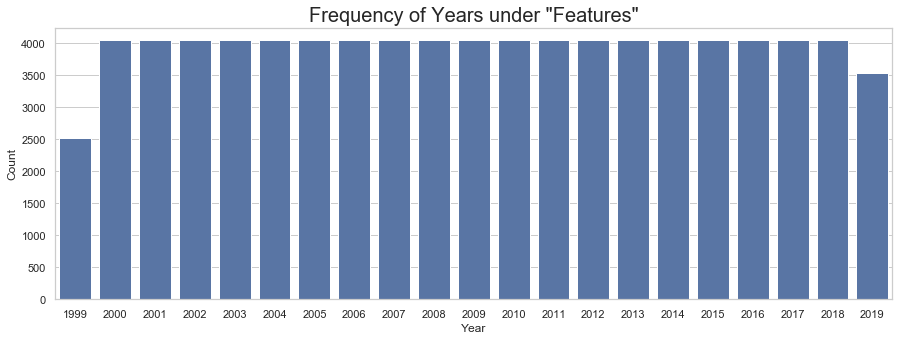

In [42]:
#years
plt.figure(figsize = [15, 5])

ax = sb.countplot(x = features_years, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Years under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-years-count.png')
plt.show()

**Observation 1:** All years between 2000 - 2018 have a consistent count at around 4,000 for all firms. 
- This makes sense, because the year 1999 is missing from all `eps_fc_terms` entries.

**Observation 2:** The years 1999 and 2019 are both *inconsistent* and *less than* the number of 4,000 counts for all other Date years.

**Observation 3:** The year 1999 has 2500 non-null entries.

**Observation 4:** The year 2019 has 3500 non-null entries.

---
**Questions:**

5) Under the "Date" field, under do the years 1999 and 2019 sum up to less than 4,000 for `eps_fc_terms` and `eod_act`?

In [43]:
#months
features_months = features_months.apply(lambda x: calendar.month_abbr[x])
months_order = ['Jan', 'Mar', 'Apr', 'Jun', 'Jul', 'Sep', 'Oct', 'Dec']

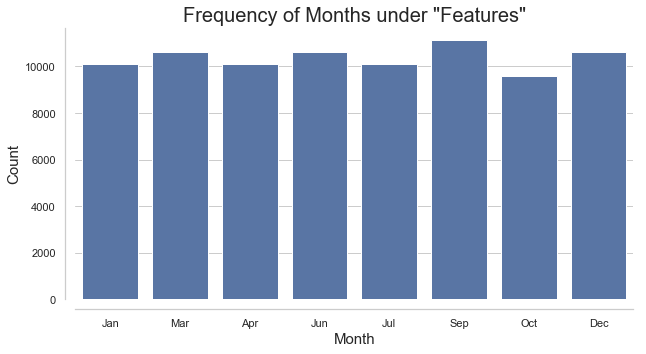

In [44]:
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features_months, color = sb.color_palette()[0], order = months_order)
ax.set(xlabel = 'Month', ylabel = 'Count')
ax.set_title('Frequency of Months under "Features"', size = 20)
sb.despine(offset = 10, trim = False)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-months-count.png')
plt.show();

**Observation 1:** September has the most number of counts at around 15,000.

**Observation 2:** October has the least number of counts at around 9,000.

**Observation 3:** The trend in counts of months under "Date" fluctuates. It is not a linear or exponential pattern; it seems that there is a "peak" in counts every 2nd *recorded* month from January.
- For example, March peaks at around 11,000 counts, then June peaks at around 10,500 counts, and Septemberat around 15,000.



### It is safe to conclude that the "Date" column is unreliable when *examining terms and years*, and should be avoided. It is better to use the "Date" column *only* when referring to specific dates.

### TERM (Features)

> As noted earlier, there are no missing values under the Term column. Therefore, all graphs below do account for `eps_act` and `eps_fc`.

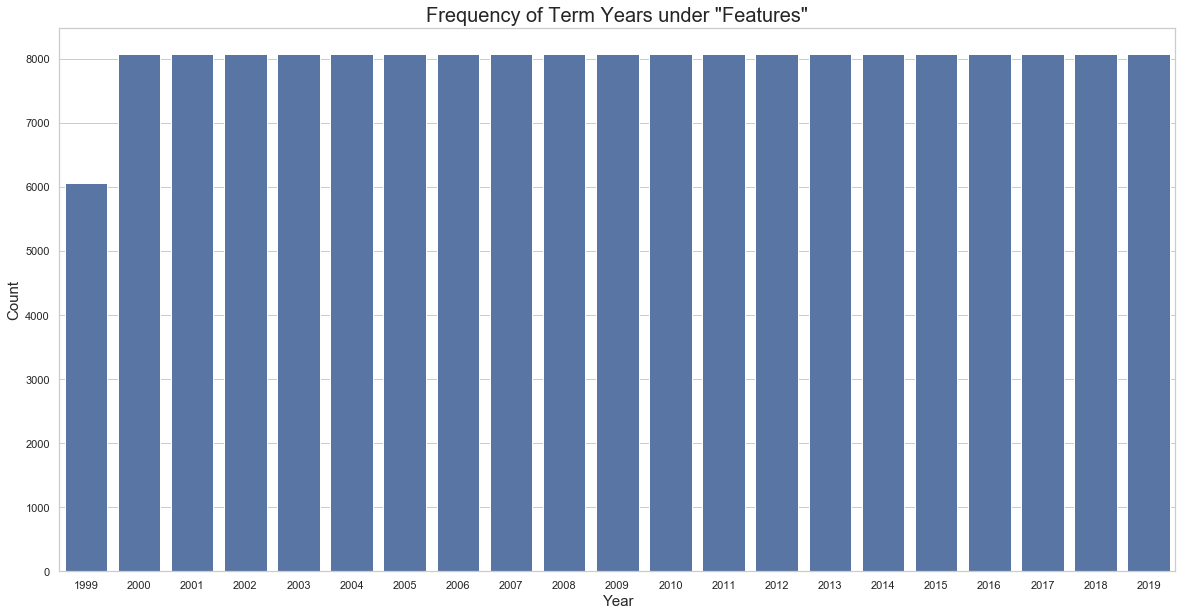

In [45]:
#years
plt.figure(figsize = [20, 10])

ax = sb.countplot(data = features, x = features.term.dt.year, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Term Years under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-years-count.png')
plt.show();

**Observation 1:** All years from 2000 to 2019 have consistent counts at 8,000 per year.

**Observation 2:** Unlike the years under Date, 1999 is the only year that does not follow the general trend. There are 6000 recorded entries containing 1999. This means that *2,000 entries do not contain the year 1999*.

---
**Questions:**
6) Which features under Term does not contain the year 1999?

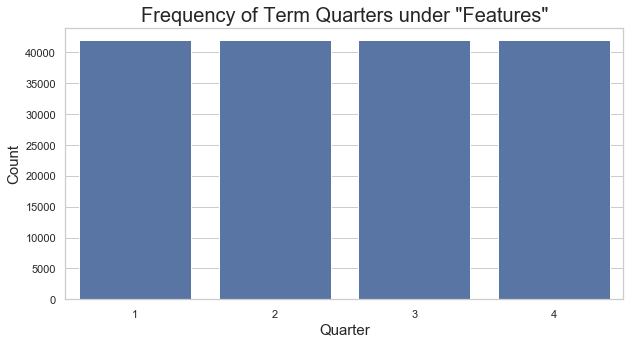

In [46]:
#quarter
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features.term.dt.quarter, color = sb.color_palette()[0])
ax.set(xlabel = 'Quarter', ylabel = 'Count')
ax.set_title('Frequency of Term Quarters under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-quarters-count.png')
plt.show();

**Observation 1:** There is a consistent number of ***quarters*** under **term**, unlike years.

**Observation 2:** This means that *quarters* is a more stable, reliable variable to examine under **Term** unlike *years*, which should be examined more closely in regard to which feature(s) contains that year.

### VALUE (Features)

In [47]:
def generate_hist(df, x, bins, title, xlabel, ylabel, save_path, csv_name):
    plt.figure(figsize = [14, 7])
    
    plt.hist(data = df, x = x, bins = bins, color = 'palevioletred')
    plt.title(title, size = 25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.savefig(save_path + csv_name)

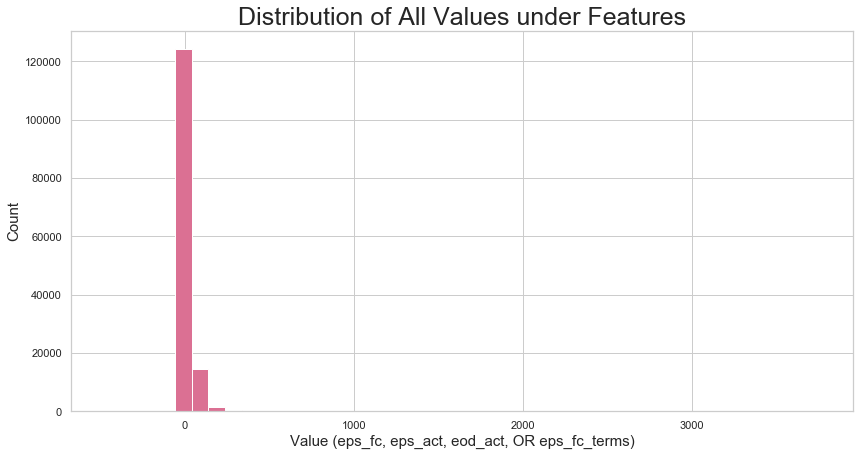

In [48]:
value_bins = np.arange(features.value.min(), features.value.max() + 100, 100)
generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist.png')

**Observation 1**: The trend in value counts is ***heavily right-skewed***

**Observation 2:** The value range 0-100 contains the highest concentration of data, with over 120,000 entries.

**Observation 3:** The value range 0-300 contains the "bulk" of all the data, which means the surrounding x-axis values are all outliers. 

---

**Questions:**

7) How do value counts under Features look like after removing all outliers around the value range 0-300?

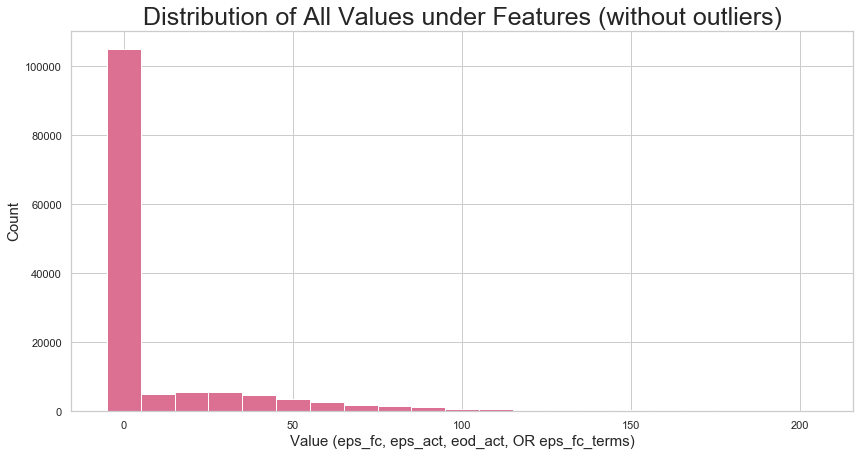

In [49]:
value_bins = np.arange(-5, 200 + 10, 10)
value_hist = generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features (without outliers)', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist-zoom-1.png')

### Question 7: How do value counts under Features look like after removing all outliers around the value range 0-300?
**Observation 1:** The graph appears to be a normal distribution with a ***strong right skew.*** This is still unlike the graph *with* all the outliers, where the right skew is much more pronounced and prominent.

**Observation 2:** Instead of breaking the bins up by bin widths of 100, the bin width here is 10.

**Observation 3:** The value range 0-10 contains the **bulk** of all the data. This is the **highest bar**, with counts of around 12,000.
- The previous graph showed that the bin range 0-100 contains around 12,000 points.
- This graph shows that the bin range 0-10 contains around 12,000 points.
- Drawing from the previous 2 observations, we can conclude that ***it's really the bin range 0-10 that contains the bulk of all the data***.

### It would be a good idea to break down the 0-10 bin range even further, and examine solely that range.

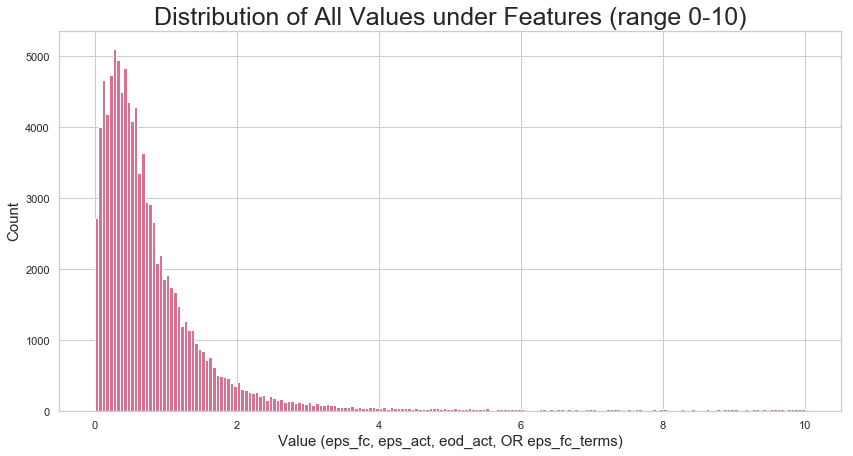

In [50]:
value_bins = np.arange(0, 10 + 0.05, 0.05)
value_hist = generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features (range 0-10)', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist-zoom-2.png')

**Observation 1:** The graph, even when zoomed in, still retains a strong right skew.

**Observation 2:** The "bulk" of the data is around the value range **0.02 to 0.05: the "peak" of the distribution.**

 

> Just to make sure this graph is skewed heavily to the right, let's create a kernel density curve:

In [51]:
def generate_distplot(data, bins):
    fig = plt.figure(figsize = [14, 7])
    ax = sb.distplot(data, bins = bins, color = 'hotpink')
    ax.minorticks_on()
    return fig, ax

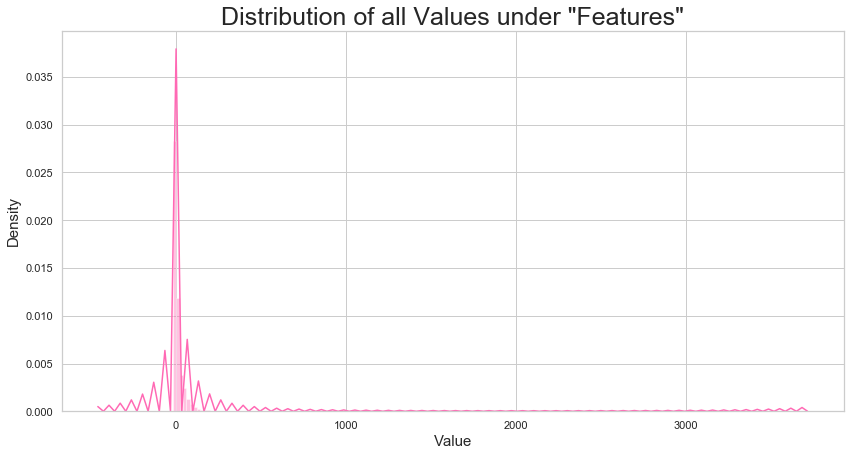

In [52]:
value_bins = np.arange(features.value.min(), features.value.max() + 20, 20)
generate_distplot(features.value.dropna(), bins = value_bins)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of all Values under "Features"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'features-value-dist.png')

**Observation:** As shown by the kernel density curve, the distribution of `values` under Features is heavily right-skewed. This means that ***most values are clustered around the left-side of the distribution*** where the mean, median, and mode are all located.

### FIRM_ID (Averages)

In [53]:
avgs_firm_id_top = avgs.firm_id.value_counts()[:20].index
avgs_firm_id_top_lim = avgs.loc[avgs.firm_id.isin(avgs_firm_id_top)]

#check there are only 20 unique values
avgs_firm_id_top_lim.firm_id.nunique()

20

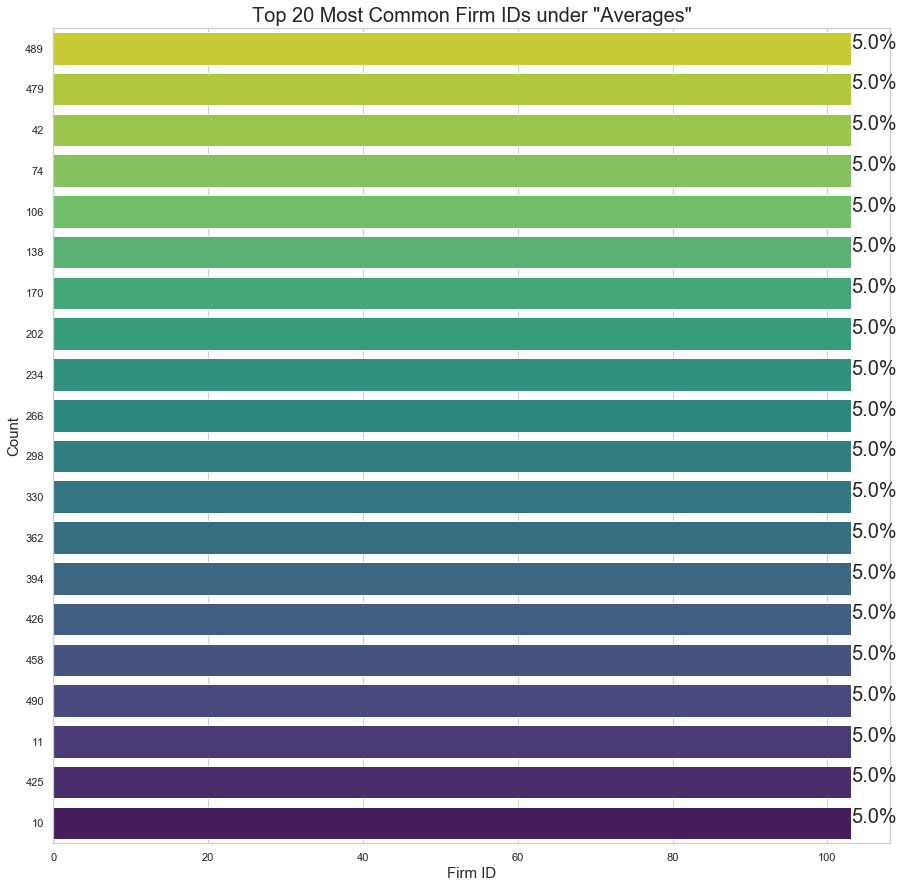

In [54]:
plt.figure(figsize = [15, 15])
x = avgs_firm_id_top_lim
num_bins = 5
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID')
plt.ylabel('Count')
plt.title('Top 20 Most Common Firm IDs under "Averages"', size = 20)

plt.savefig(PATH_UNIVARIATE + 'avgs-firm-id-count-top.png');
plt.show();

In [55]:
avgs_firm_id_bottom = avgs.firm_id.value_counts()[-20:].index
avgs_firm_id_bottom_lim = avgs.loc[avgs.firm_id.isin(avgs_firm_id_top)]

#check there are only 20 unique values
avgs_firm_id_bottom_lim.firm_id.nunique()

20

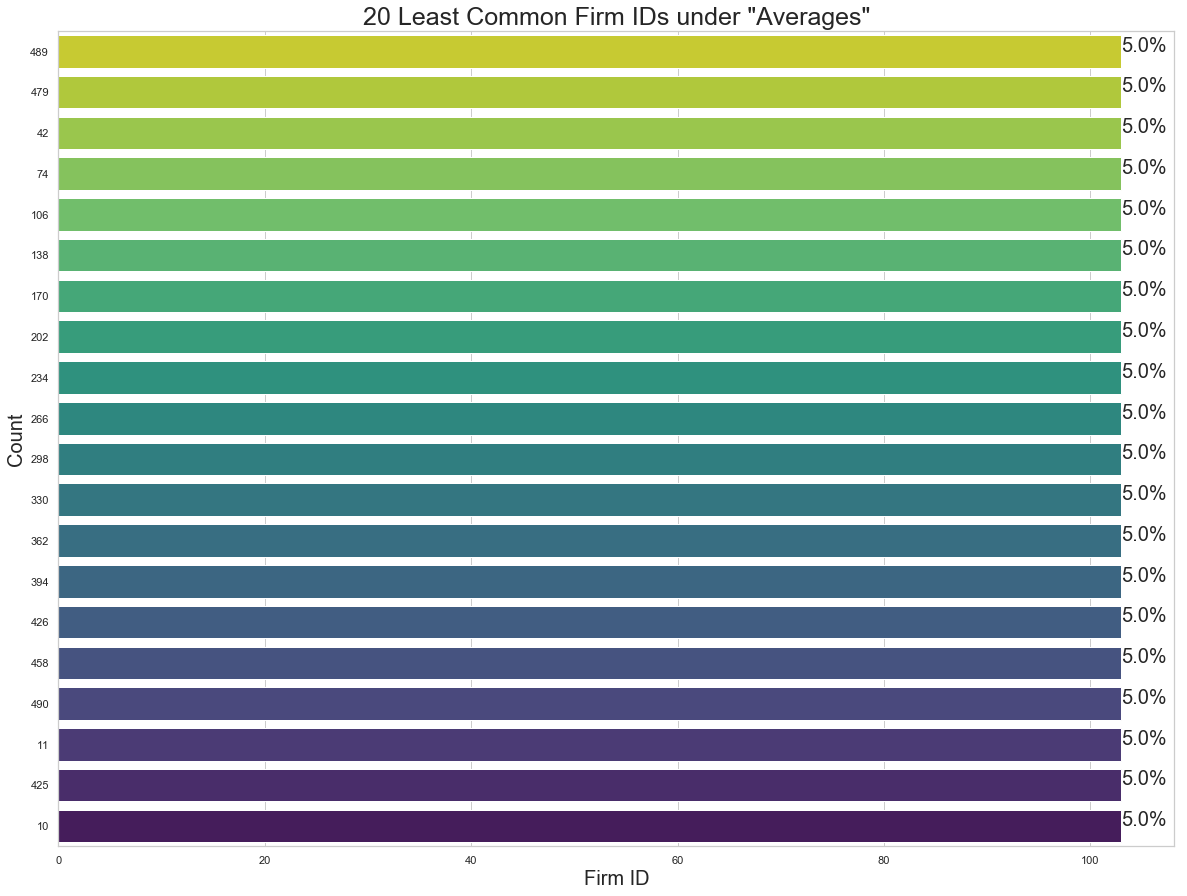

In [56]:
plt.figure(figsize = [20, 15])
x = avgs_firm_id_bottom_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('20 Least Common Firm IDs under "Averages"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'avgs-firm-id-count-bottom.png');
plt.show();

**Observation 1:** Both the 20 most common and least common Firm IDs all make up the same proportion of existing Firm IDs: 5.0% each. This means that under "Averages", there is a **consistent count among all Firm IDs** at around 105.

In [57]:
#check consistency of counts among firm_ids
firm_counts = avgs.firm_id.value_counts()
np.unique(firm_counts.sort_values().values)

array([103], dtype=int64)

> I discovered that ***all firm id counts are consistent across the entire avgs.csv dataset*** at 105 entries per firm id. There are no null firm ids.

### AVERAGE (Averages)

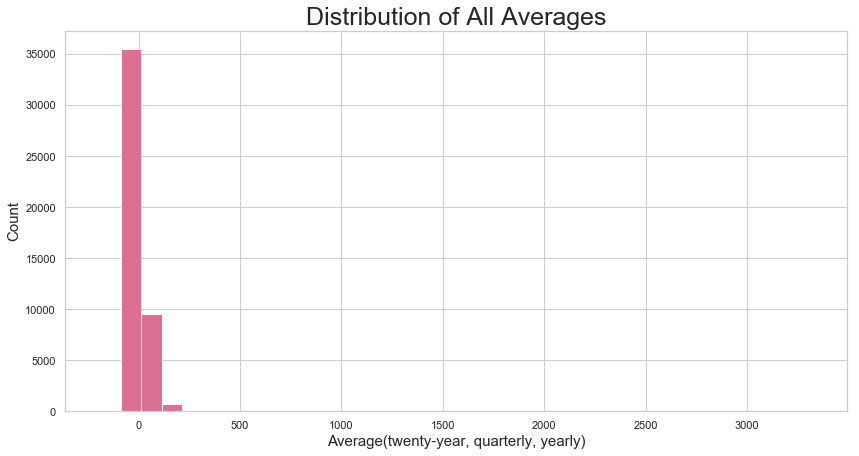

In [58]:
value_bins = np.arange(avgs.average.min(), avgs.average.max() + 100, 100)
generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages', 
                'Average(twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avg-hist.png')

**Observation 1**: The trend in value counts is ***heavily right-skewed***

**Observation 2:** The value range 0-100 contains the highest concentration of data, with around 36,000 entries.

**Observation 3:** The value range 0-300 contains the "bulk" of all the data, which means the surrounding x-axis values are all outliers. 

**Observation 4:** There is a ***all values, whether under Features or Averages, share a common theme of taking up the "bulk" of data in the same bin range***

---

**Questions:**

8) How do value counts under Averages look like after removing all outliers around the value range 0-300?

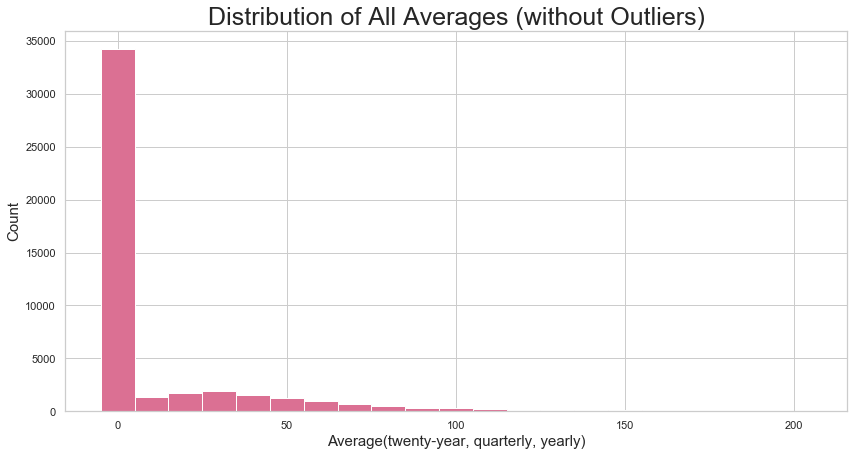

In [59]:
value_bins = np.arange(-5, 200 + 10, 10)
generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages (without Outliers)', 
                'Average(twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avg-hist-zoom-1.png')

### Question 8: How do average counts under Averages look like after removing all outliers around the value range 0-300?
**Observation 1:** The graph appears to be a normal distribution with a ***strong right skew.*** This is still unlike the previous graph *with* all the outliers, where the right skew is much more pronounced and prominent.

**Observation 2:** Instead of breaking the bins up by bin widths of 100, the bin width here is 10.

**Observation 3:** The value range 0-10 contains the **bulk** of all the data. This is the **highest bar**, with counts of around 12,000.
- The previous graph showed that the bin range 0-100 contains around 36,000 points.
- This graph shows that the bin range 0-10 contains around 34,000 points.
- Drawing from the previous 2 observations, we can conclude that ***it's really the bin range 0-10 that contains the bulk of all the data***, with the other ~2,000 points being scattered among the bins from 10 to 110.

**Observation 4:** Among the bins from 10 to 110 that contain the other 2,000 points, the bin 30-40 contains the "bulk" of that data at around 2,000 points.

### It would be a good idea to break down the 0-10 bin range even further for Averages, and examine solely that range.

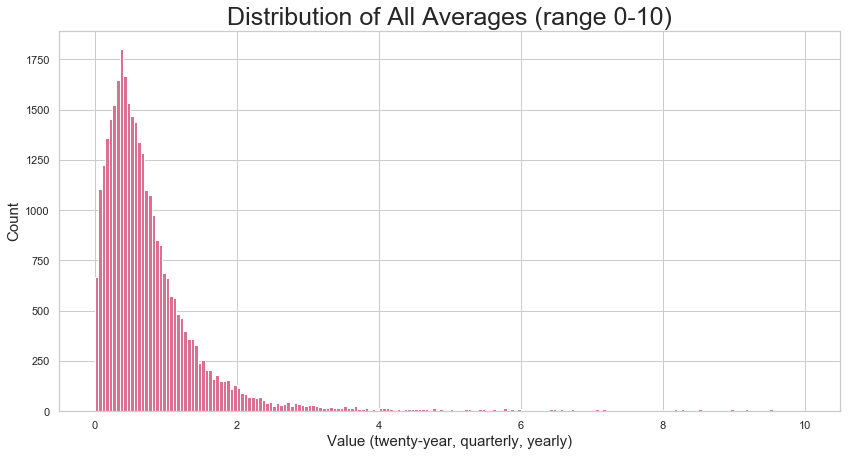

In [60]:
value_bins = np.arange(0, 10 + 0.05, 0.05)
value_hist = generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages (range 0-10)', 
                'Value (twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avgs-hist-zoom-2.png')

**Observation 1:** The graph, even when zoomed in, still retains a strong right skew.

**Observation 2:** The "bulk" of the data is around the value range **0.02 to 0.05: the "peak" of the distribution.**

> Just to make sure this graph is skewed heavily to the right, let's create a kernel density curve:

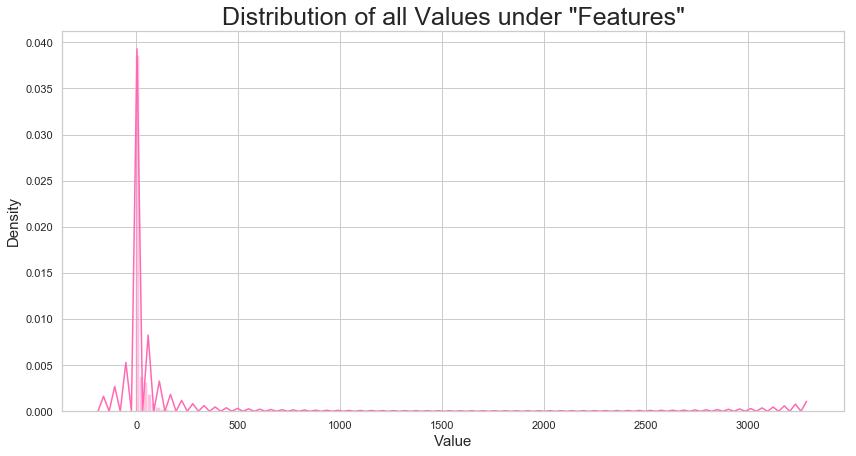

In [61]:
value_bins = np.arange(avgs.average.min(), avgs.average.max() + 20, 20)
generate_distplot(avgs.average.dropna(), bins = value_bins)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of all Values under "Features"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'avgs-average-dist.png')

**Observation:** As shown by the kernel density curve, the distribution of `average` under Averages is heavily right-skewed. This means that ***most averages are clustered around the left-side of the distribution*** where the mean, median, and mode are all located.


**A KEY TAKEAWAY:** There is a strong congruency between the distribution patterns of ***values under Features*** and ***averages under Averages***. 
> This is perhaps because TK

### AVERAGE TYPE (Averages)

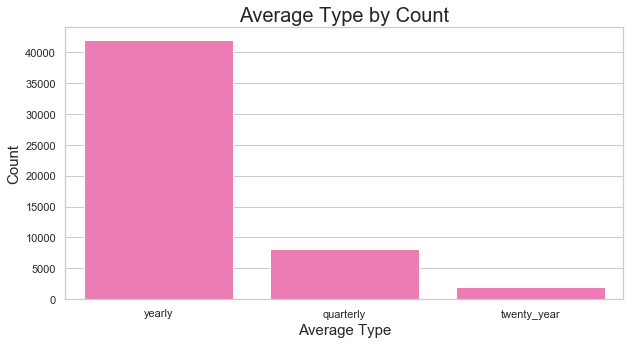

In [62]:
plt.figure(figsize = [10, 5])
cat_order = avgs.average_type.value_counts().index
sb.countplot(data = avgs, x = 'average_type', color = 'hotpink', order = cat_order)
plt.xlabel('Average Type')
plt.ylabel('Count')
plt.title('Average Type by Count', size = 20)
plt.savefig(PATH_UNIVARIATE + 'avgs-avgtype-count.png')

**Observation 1:** Under Averages, **yearly** data has the highest number of counts while **twenty-year** data has the least number of counts. This all makes sense, as there are more yearly averages than quarters per firm, and more quarters than twenty-year entries per firm.
- For each firm, there are around 20 yearly averages (1999 to 2019) for each of the 4 features. (80 total per firm).
- For each firm, there are 4 quarterly averages for each of the 4 features. (16 total per firm)
- For each firm, there is 1 twenty-year average for each of the 4 features. (4 total per firm)

**Note:** number of entries may vary for *yearly averages* because the year 1999 and 2019 are missing for some features.

In [63]:
#keep for analysis, delete when done w/ report
len(avgs.query('average_type == "yearly" and firm_id == 0'))

83

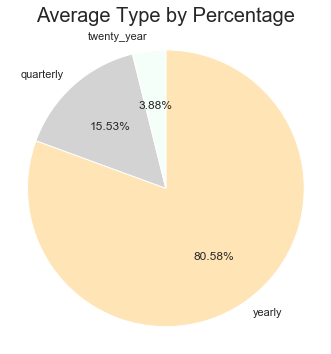

In [66]:
colors = random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)

plt.figure(figsize = [10, 5])
cs=cm.Set1(np.arange(40)/40.)

plt.pie(avgs.average_type.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = avgs.average_type.value_counts().index, colors = colors);
plt.suptitle('Average Type by Percentage', size = 20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.axis('square');
plt.savefig(PATH_UNIVARIATE + 'avgs-avgtype-pie.png')

**Observation 1:** As expected, yearly average types make up the majority of all entries at 80.58%.

**Observation 2:** As expected, twenty-year average types make up the least portion of all entries at 3.88%.

**Observation 3:** These percentages are consistent with the previous counts.

### TIME_PERIOD (Averages)

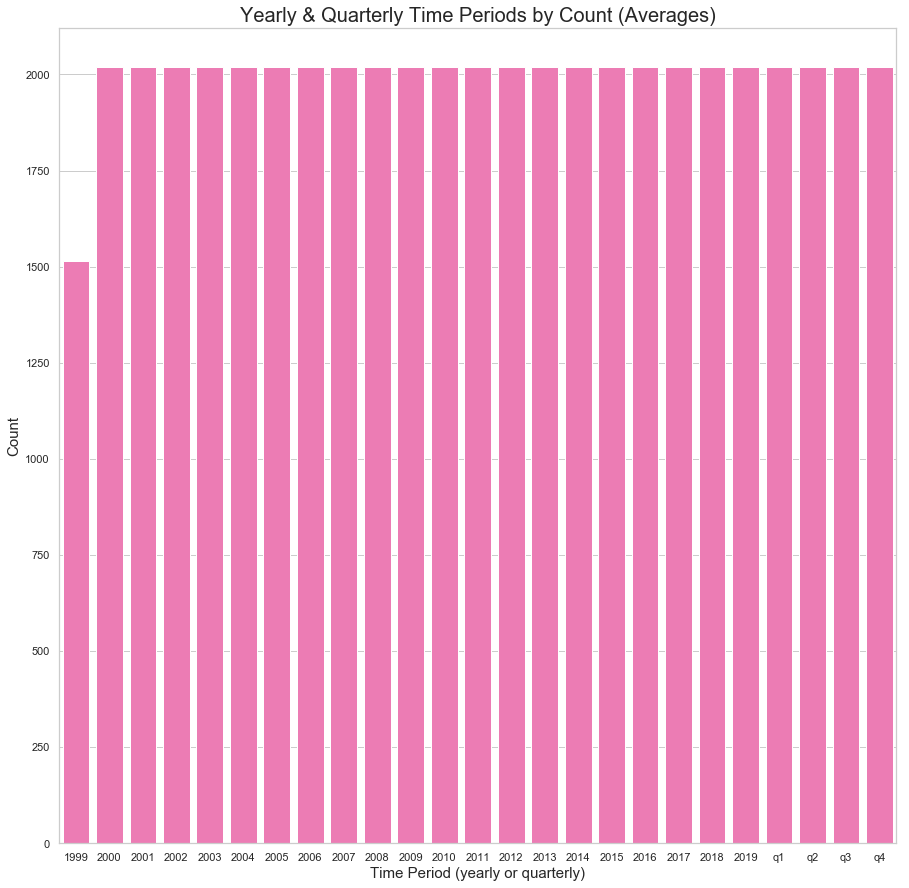

In [67]:
plt.figure(figsize = [15, 15])
cat_order = avgs.time_period.value_counts().sort_index().index
sb.countplot(data = avgs, x = 'time_period', color = 'hotpink', order = cat_order)
plt.xlabel('Time Period (yearly or quarterly)')
plt.ylabel('Count')
plt.title('Yearly & Quarterly Time Periods by Count (Averages)', size = 20)
plt.savefig(PATH_UNIVARIATE + 'avgs-time-period-hist.png')

> I decided to portray ***both yearly and quarterly Time Periods*** in the same countplot because q1-q4 and the years 2000-2019 show consistent counts.

**Observation 1:** All years from 2000-2019 **and** all quarters show consistent counts, at just over 2,000 entries each.

**Observation 2:** The year 1999 has the least amount of counts, at only around 1510. This is because the feature `eps_fc_terms` does not contain the year 1999.

**Observation 3:** The time period for `twenty-year` averages does not show because by default, all Time Period entries associated with average type of `twenty-year` is set to null.

### FEATURE (Averages)

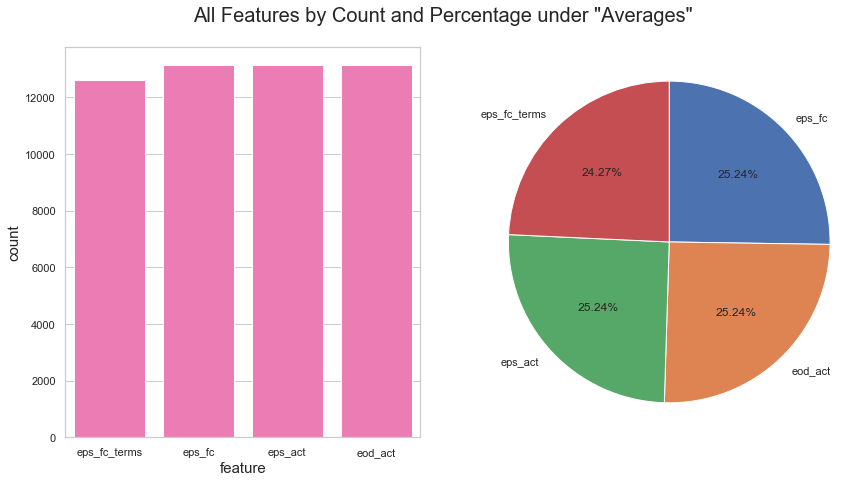

In [68]:
plt.figure(figsize = [14, 7])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
# generate_pct_bar(avgs, 'feature', 'Blues_d')
sb.countplot(data = avgs, x = avgs.feature, color = 'hotpink', order = cat_order)

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = avgs['feature'].value_counts()
plt.pie(avgs.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = avgs.feature.value_counts().index);
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Averages"', size = 20)
# plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'avgs-feature-hist-pie.png')

**Observation 1:** `eps_act`, `eps_fc`, and `eod_act` all show consistent counts at around 13,000 entries each (25.24% each).

**Observation 2:** `eps_fc_terms` is the only *feature type* to deviate from the others, having less entries at around 12,500 (24.27%).

**Observation 3:** It makes sense that `eps_fc_terms` contains missing data, because ***the year 1999 was not included while gathering this data.*** This effectively removes around 500 entries: not a substantial amount of data.

## IV) Bivariate Exploration<a id = "bi"></a>

> General rule: The *closer* the eps_act - eps_fc difference is to 0, the *more accurate* the forecast.

### DIFFERENCE IN TWENTY YEAR AVERAGE OF EPS_FC AND EPS_ACT BY FIRM (Averages)

In [69]:
#array of all firm ids
ids = firm_ids.firm_id.values

In [70]:
#put eps_fc and eps_act averages into separate DFs
avgs_eps_fc = avgs[avgs['feature'] == 'eps_fc']
avgs_eps_act = avgs[avgs['feature'] == 'eps_act']

In [71]:
#isolate eps_fc and eps_act DFs by "twenty_year" average type
avgs_eps_fc_twenty = avgs_eps_fc[avgs_eps_fc['average_type'] == 'twenty_year']
avgs_eps_act_twenty = avgs_eps_act[avgs_eps_act['average_type'] == 'twenty_year']

In [72]:
#df of only twenty-year average types
avgs_twenty = pd.concat([avgs_eps_fc_twenty, avgs_eps_act_twenty])

In [73]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_twenty = avgs_twenty.query('feature == "eps_fc"').average.values
avg_eps_act_twenty = avgs_twenty.query('feature == "eps_act"').average.values
twenty_diff_data = list(zip(ids, avg_eps_fc_twenty, avg_eps_act_twenty))

twenty_diffs = pd.DataFrame(twenty_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
twenty_diffs['difference'] = twenty_diffs['average_eps_fc'] - twenty_diffs['average_eps_act']
twenty_diffs['average_type'] = 'twenty_year'

In [74]:
twenty_diffs.sample(5)

,firm_id,average_eps_fc,average_eps_act,difference,average_type
307,307,0.473107,0.290947,0.182160,twenty_year
360,360,1.211024,1.218771,-0.007747,twenty_year
76,76,0.202915,-0.031687,0.234602,twenty_year
179,179,0.809207,0.320530,0.488677,twenty_year
377,377,1.406131,1.483841,-0.077711,twenty_year


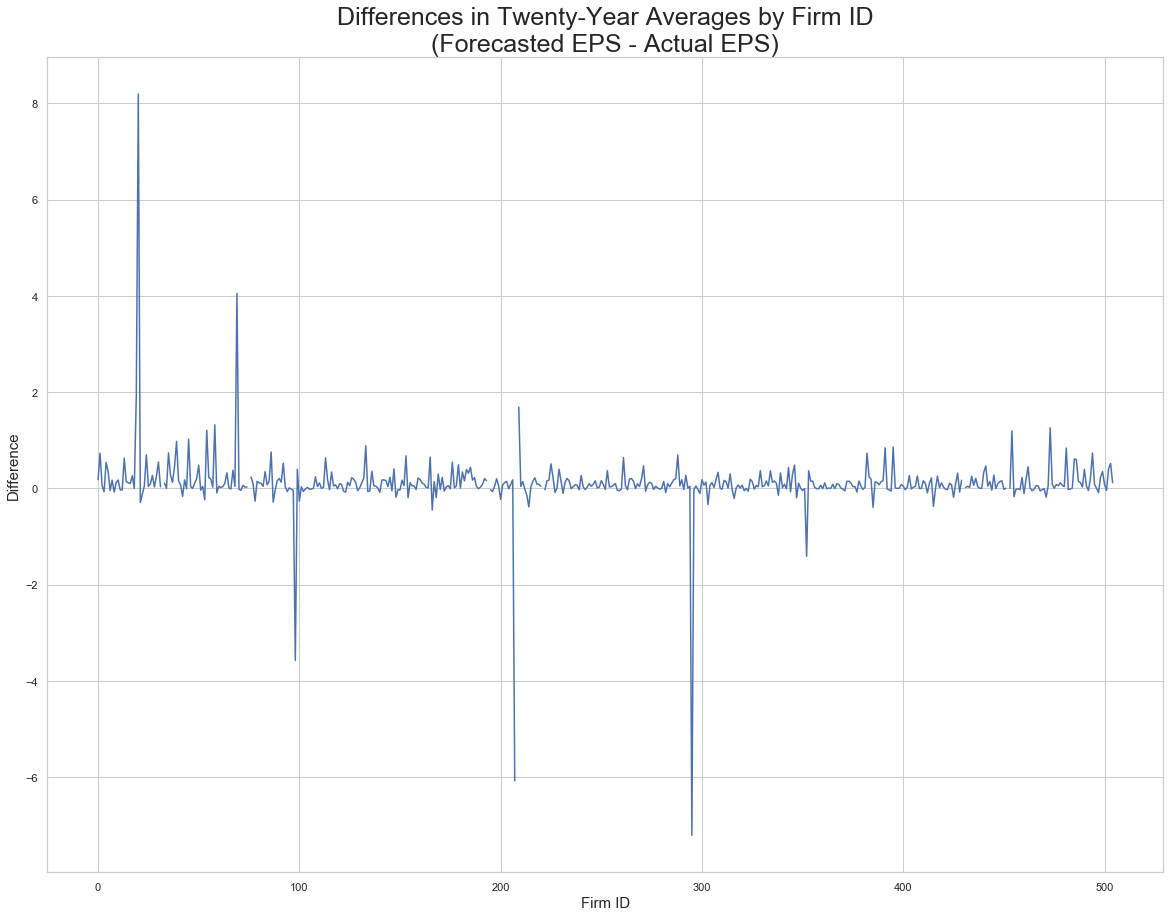

In [75]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Difference', size = 15)
plt.title('Differences in Twenty-Year Averages by Firm ID\n(Forecasted EPS - Actual EPS)', size = 25)
plt.plot(twenty_diffs['firm_id'], twenty_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year.png')
plt.show();

### DIFFERENCE IN QUARTERLY AVERAGE OF EPS_FC AND EPS_ACT (Averages)

In [76]:
#isolate eps_fc and eps_act DFs by "quarterly" average type
avgs_eps_fc_quarter = avgs_eps_fc[avgs_eps_fc['average_type'] == 'quarterly']
avgs_eps_act_quarter = avgs_eps_act[avgs_eps_act['average_type'] == 'quarterly']

In [77]:
#df of only quarterly averages
avgs_quarter = pd.concat([avgs_eps_fc_quarter, avgs_eps_act_quarter])

In [78]:
#get the average average separately per firm
avgs_quarter_sep = avgs_quarter.groupby(['firm_id', 'feature']).mean().reset_index()
avgs_quarter_sep.shape[0]

1010

In [79]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_quarter = avgs_quarter_sep.query('feature == "eps_fc"').average.values
avg_eps_act_quarter = avgs_quarter_sep.query('feature == "eps_act"').average.values

quarter_diff_data = list(zip(ids, avg_eps_fc_quarter, avg_eps_act_quarter))

quarter_diffs = pd.DataFrame(quarter_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
quarter_diffs['difference'] = quarter_diffs['average_eps_fc'] - quarter_diffs['average_eps_act']
quarter_diffs['average_type'] = 'quarter'

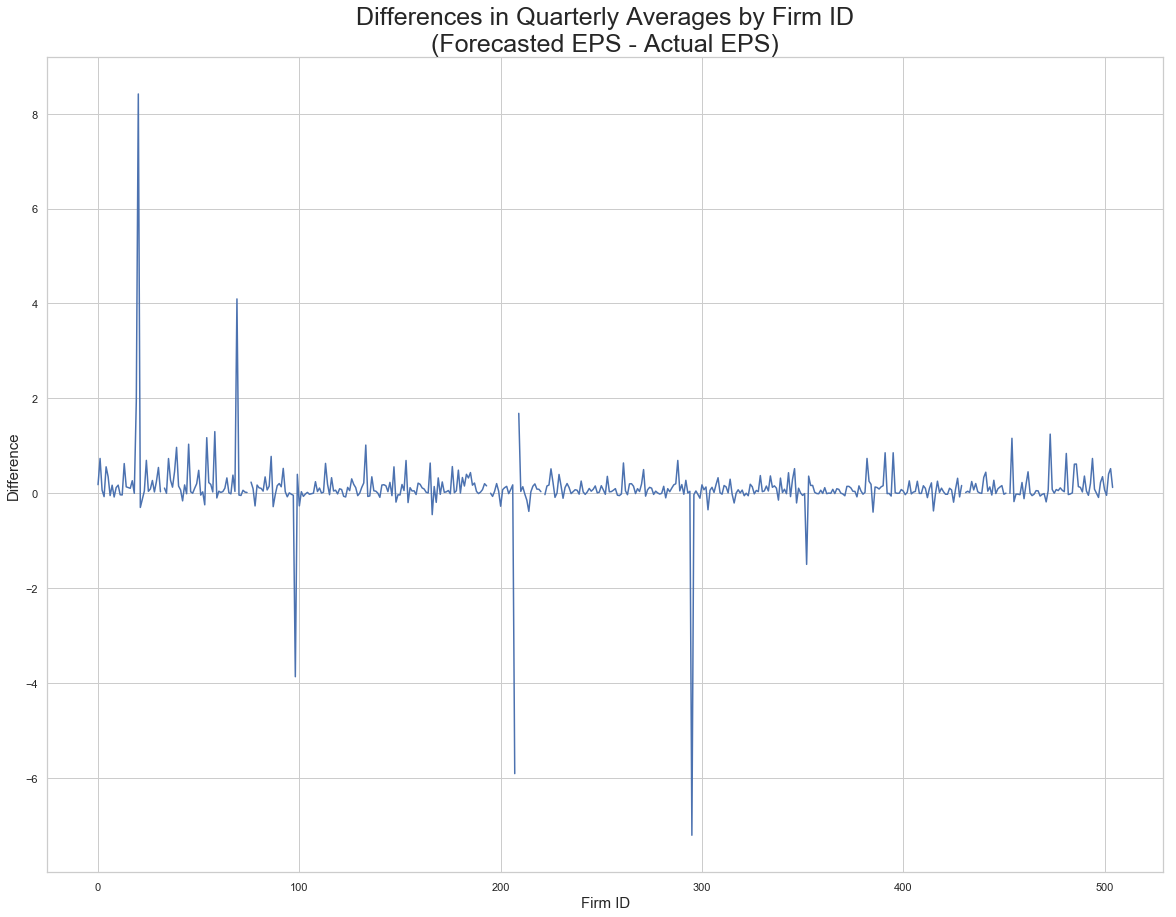

In [80]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Difference', size = 15)
plt.title('Differences in Quarterly Averages by Firm ID\n(Forecasted EPS - Actual EPS)', size = 25)
plt.plot(quarter_diffs['firm_id'], quarter_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter.png')
plt.show();

### DIFFERENCE IN YEARLY AVERAGE OF EPS_FC AND EPS_ACT (Averages)

In [81]:
#isolate eps_fc and eps_act DFs by "yearly" average type
avgs_eps_fc_year = avgs_eps_fc[avgs_eps_fc['average_type'] == 'yearly']
avgs_eps_act_year = avgs_eps_act[avgs_eps_act['average_type'] == 'yearly']

In [82]:
#df of only yearly averages
avgs_year = pd.concat([avgs_eps_fc_year, avgs_eps_act_year])

In [83]:
#get the average average separately per firm
avgs_year_sep = avgs_year.groupby(['firm_id', 'feature']).mean().reset_index()
avgs_year_sep.sample(5)

,firm_id,feature,average
283,141,eps_fc,0.362107
876,438,eps_act,0.579286
543,271,eps_fc,0.765450
486,243,eps_act,0.562804
306,153,eps_act,0.186112


In [84]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_year = avgs_year_sep.query('feature == "eps_fc"').average.values
avg_eps_act_year = avgs_year_sep.query('feature == "eps_act"').average.values

year_diff_data = list(zip(ids, avg_eps_fc_year, avg_eps_act_year))

year_diffs = pd.DataFrame(year_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
year_diffs['difference'] = year_diffs['average_eps_fc'] - year_diffs['average_eps_act']
year_diffs['average_type'] = 'year'

In [85]:
avgs_eps_fc_year.feature.nunique()

1

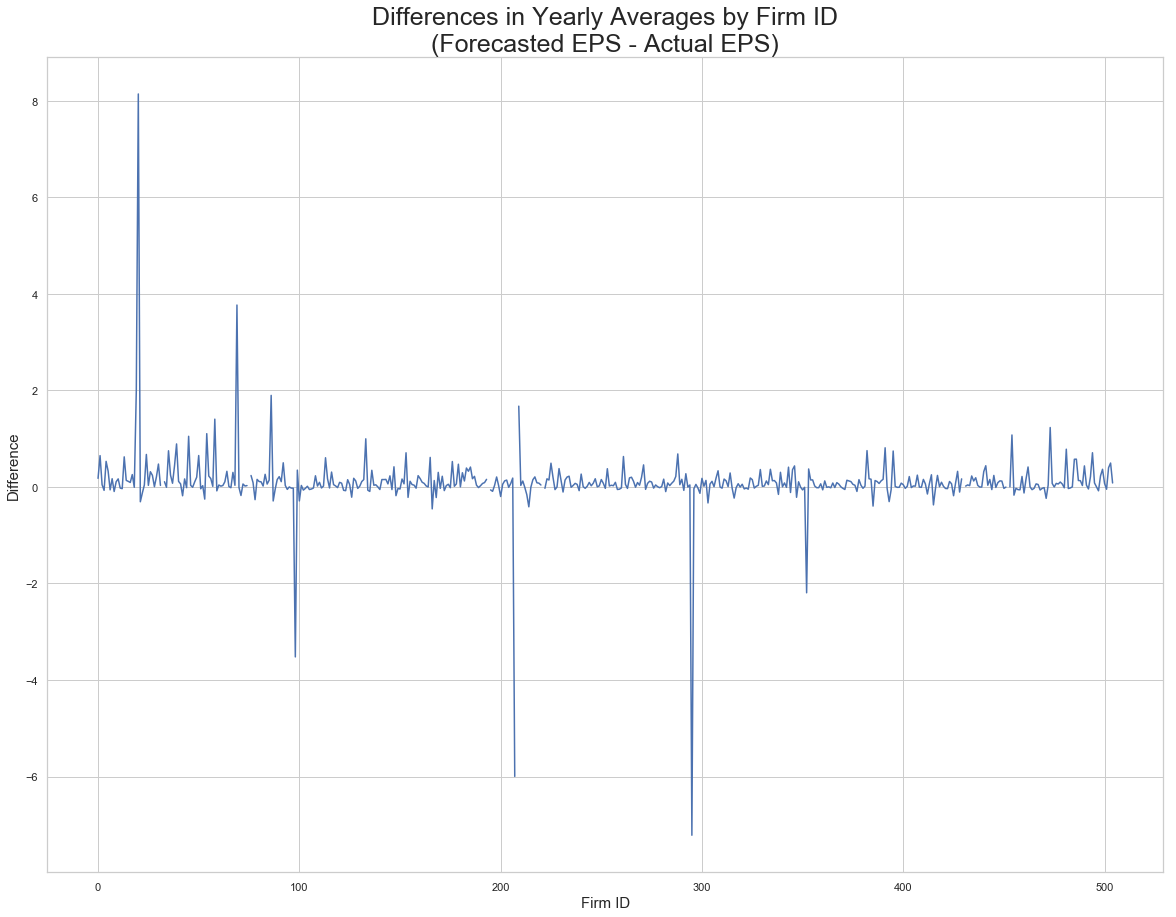

In [86]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Difference', size = 15)
plt.title('Differences in Yearly Averages by Firm ID\n(Forecasted EPS - Actual EPS)', size = 25)
# plt.title('(Average Forecasted EPS - Average Actual EPS)')
# plt.rcParams = plt.rcParamsDefault
plt.plot(year_diffs['firm_id'], year_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-year.png')
plt.show();

- Put all the above graphs into a single FacetGrid for easy accessibility and comparing, in the Multivariate Exploration stage.

In [87]:
#put all yearly, quarterly, and twenty-year differences into one DF
all_diffs = pd.concat([twenty_diffs, quarter_diffs, year_diffs])
all_diffs.sample(5)

,firm_id,average_eps_fc,average_eps_act,difference,average_type
226,226,2.176278,1.945124,0.231153,quarter
268,268,0.716738,0.625586,0.091152,year
3,3,0.873143,0.944501,-0.071358,quarter
174,174,0.718762,0.664189,0.054573,twenty_year
394,394,0.297917,0.353050,-0.055133,year


- Now that we looked at the raw data, let's create a line plot depicting the ***average difference among all average types.***

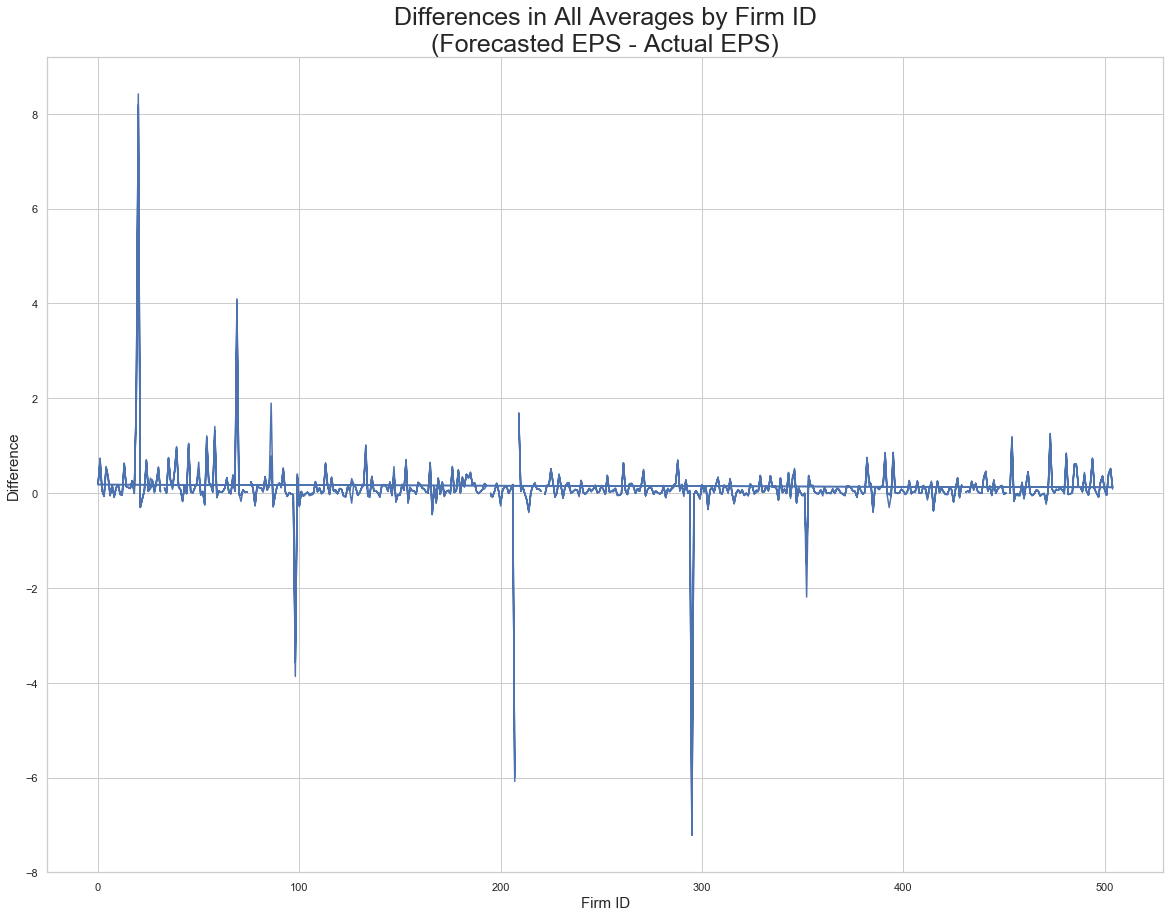

In [88]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Difference', size = 15)
plt.title('Differences in All Averages by Firm ID\n(Forecasted EPS - Actual EPS)', size = 25)
plt.plot(all_diffs['firm_id'], all_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-all.png')
plt.show();

**Observation:** Since ***all graphs depicting the average differences of forecasted and actual EPS, it is safe to use the `all_diffs` DF*** to answer for the yearly, quarterly, and twenty-year interpretations.

### Approach: Isolate the top 20 firms with the *largest absolute differences* (most inaccurate) and the top 20 firms with the *smallest absolute differences* (most accurate)

In [300]:
#helper function to convert an array for firm_ids to their ticks
def convert_ids_to_ticks(df):
    return df.firm_id.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values

**Twenty-Year**

In [89]:
#isolate firm ID and difference into its own series
twenty_diffs_abs = twenty_diffs[['firm_id', 'difference']]
twenty_diffs_abs.difference = twenty_diffs_abs.difference.abs()

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [90]:
#get firm IDs of both top 20 firms by difference
twenty_diffs_top = twenty_diffs_abs.sort_values(by='difference', ascending = False).head(20)
twenty_diffs_bottom = twenty_diffs_abs.sort_values(by='difference', ascending = True).head(20)

In [304]:
#obtain firm TICKS by FIRM ID
twenty_top_ticks = convert_ids_to_ticks(twenty_diffs_top)
twenty_bottom_ticks = convert_ids_to_ticks(twenty_diffs_bottom)

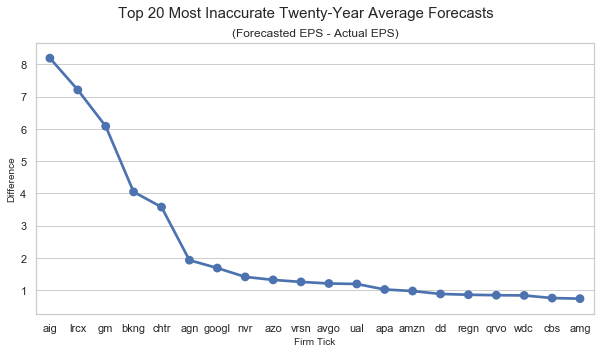

In [92]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [10, 5])

sb.pointplot(x = twenty_top_ticks, y = twenty_diffs_top.difference.values)

plt.suptitle('Top 20 Most Inaccurate Twenty-Year Average Forecasts', size = 15)
plt.title('(Forecasted EPS - Actual EPS)')
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year-top.png')

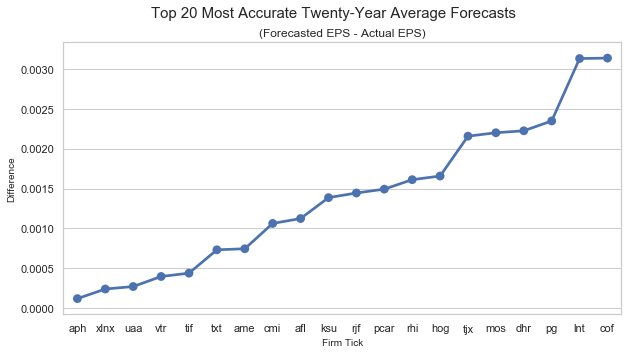

In [93]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [10, 5])

sb.pointplot(x = twenty_bottom_ticks, y = twenty_diffs_bottom.difference.values)

plt.suptitle('Top 20 Most Accurate Twenty-Year Average Forecasts', size = 15)
plt.title('(Forecasted EPS - Actual EPS)')
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year-bottom.png')

### Linear Regression Test For All EPS_FC and EPS_ACT Twenty-Year Averages

**Quarterly**

In [94]:
#isolate firm ID and difference into its own series
quarter_diffs_abs = quarter_diffs[['firm_id', 'difference']]
quarter_diffs_abs.difference = quarter_diffs_abs.difference.abs()

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [95]:
#get firm IDs of both top 20 firms by difference
quarter_diffs_top = quarter_diffs_abs.sort_values(by='difference', ascending = False).head(20)
quarter_diffs_bottom = quarter_diffs_abs.sort_values(by='difference', ascending = True).head(20)

In [96]:
#obtain firm TICKS by FIRM ID
quarter_top_ticks = quarter_diffs_top.firm_id.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values
quarter_bottom_ticks = quarter_diffs_bottom.firm_id.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values

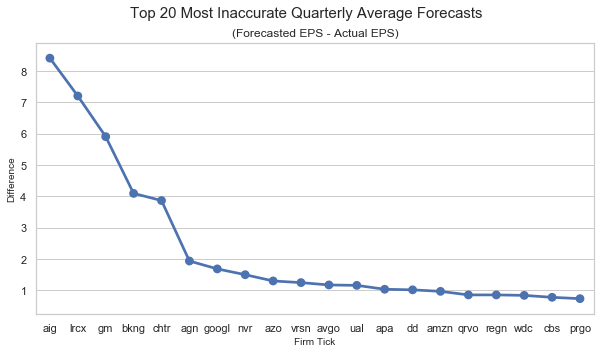

In [97]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [10, 5])

sb.pointplot(x = quarter_top_ticks, y = quarter_diffs_top.difference.values)

plt.suptitle('Top 20 Most Inaccurate Quarterly Average Forecasts', size = 15)
plt.title('(Forecasted EPS - Actual EPS)')
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter-top.png')

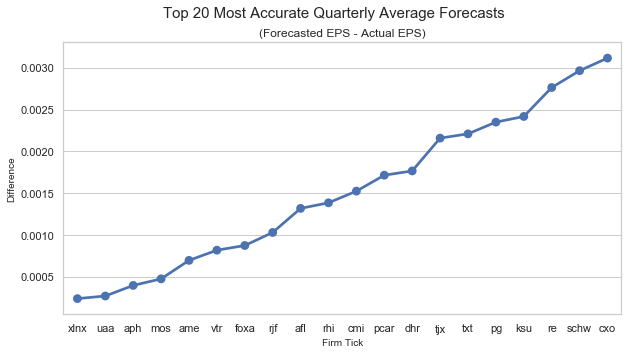

In [98]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [10, 5])

sb.pointplot(x = quarter_bottom_ticks, y = quarter_diffs_bottom.difference.values)

plt.suptitle('Top 20 Most Accurate Quarterly Average Forecasts', size = 15)
plt.title('(Forecasted EPS - Actual EPS)')
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter-bottom.png')

In [99]:
#get firm IDs of both top 20 firms by difference
twenty_diffs_top = twenty_diffs.sort_values(by='difference', ascending = False).head(20)
twenty_diffs_bottom = twenty_diffs.sort_values(by='difference', ascending = True).head(20)

In [100]:
#isolate firm ID and difference into its own series
year_diffs_abs = year_diffs[['firm_id', 'difference']]
year_diffs_abs.difference = year_diffs_abs.difference.abs()

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [101]:
#get firm IDs of both top 20 firms by difference
year_diffs_top = year_diffs_abs.sort_values(by='difference', ascending = False).head(20)
year_diffs_bottom = year_diffs_abs.sort_values(by='difference', ascending = True).head(20)

In [102]:
#obtain firm TICKS by FIRM ID
year_top_ticks = year_diffs_top.firm_id.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values
year_bottom_ticks = year_diffs_bottom.firm_id.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values

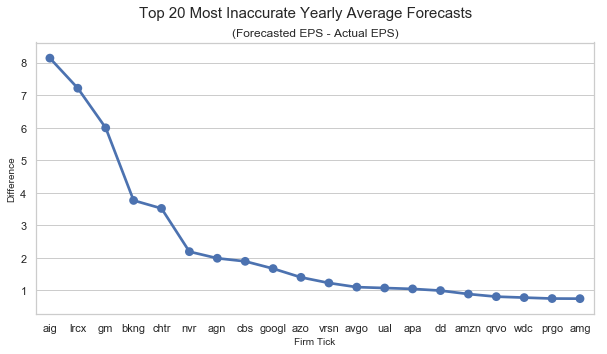

In [103]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [10, 5])

sb.pointplot(x = year_top_ticks, y = year_diffs_top.difference.values)

plt.suptitle('Top 20 Most Inaccurate Yearly Average Forecasts', size = 15)
plt.title('(Forecasted EPS - Actual EPS)')
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-year-top.png')

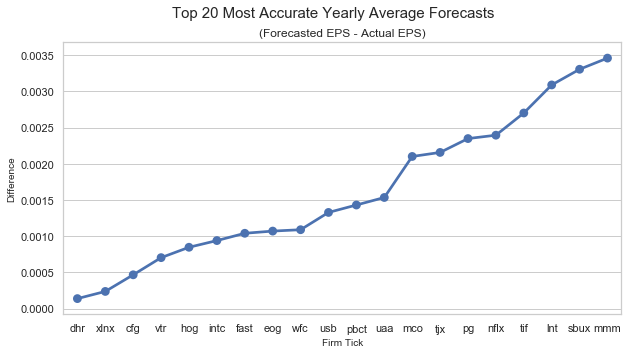

In [104]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [10, 5])

sb.pointplot(x = year_bottom_ticks, y = year_diffs_bottom.difference.values)

plt.suptitle('Top 20 Most Accurate Yearly Average Forecasts', size = 15)
plt.title('(Forecasted EPS - Actual EPS)')
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-year-bottom.png')

In [105]:
avgs.shape[0]

52015

**Twenty-Year, Quarterly, and Yearly**

> Main question: How do firms differ by forecast inaccuracy by average type (yearly, quarterly, and yearly)?

**Steps:**

1) Calculate the *average yearly, quarterly, and twenty-difference* for each firm.

2) Convert the new average differences to their absolute value.

3) Isolate the top 20 and bottom 20 firms by their average distances.

4) Convert Firm IDs to Firm Ticks

5) Use those firm ticks to create a visualization using 2 different datasets:
- the `avgs` DF (all raw data)
- the `all_diffs` DF (filtered data)

In [106]:
#calculate average difference for all average types
all_diffs_avg = all_diffs.groupby('firm_id').mean().reset_index()

In [107]:
#isolate firm ID and difference into its own series
all_diffs_abs = all_diffs_avg[['firm_id', 'difference']]
all_diffs_abs.difference = year_diffs_abs.difference.abs()

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [108]:
#get firm IDs of both top 20 firms by difference
all_diffs_top = all_diffs_abs.sort_values(by='difference', ascending = False).head(20)
all_diffs_bottom = all_diffs_abs.sort_values(by='difference', ascending = True).head(20)

In [109]:
#obtain firm TICKS by FIRM ID
all_top_ticks = all_diffs_top.firm_id.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values
all_bottom_ticks = all_diffs_bottom.firm_id.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values

In [110]:
#isolate avgs by ticks
df_avgs_top_ticks = avgs[avgs['firm_id'].isin(all_diffs_top.firm_id.values)]
df_avgs_bottom_ticks = avgs[avgs['firm_id'].isin(all_diffs_bottom.firm_id.values)]

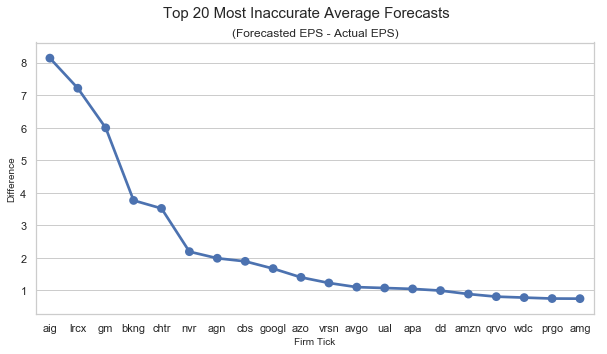

In [111]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [10, 5])

sb.pointplot(x = all_top_ticks, y = all_diffs_top.difference.values)

plt.suptitle('Top 20 Most Inaccurate Average Forecasts', size = 15)
plt.title('(Forecasted EPS - Actual EPS)')
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-top.png')

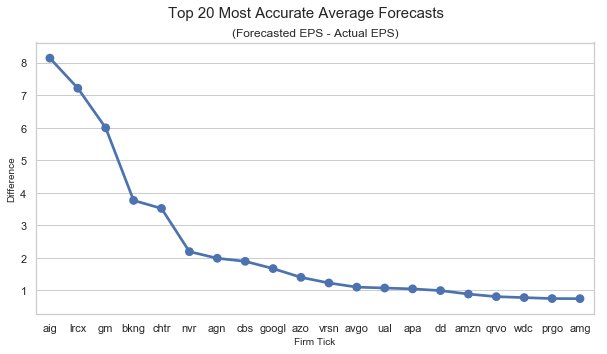

In [112]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [10, 5])

sb.pointplot(x = all_top_ticks, y = all_diffs_top.difference.values)

plt.suptitle('Top 20 Most Accurate Average Forecasts', size = 15)
plt.title('(Forecasted EPS - Actual EPS)')
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-bottom.png')

<Figure size 504x504 with 0 Axes>

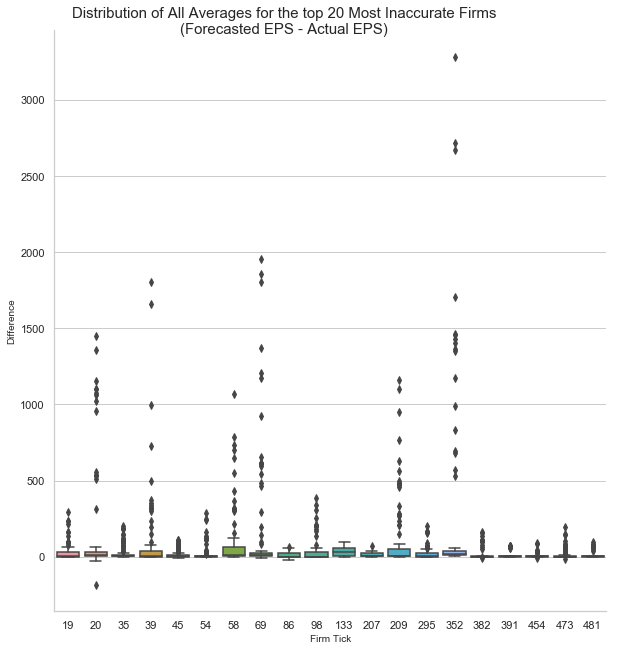

In [113]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [7, 7])

g = sb.catplot(x = 'firm_id', y = 'average', data = df_avgs_top_ticks, kind = "box")

plt.suptitle('Distribution of All Averages for the top 20 Most Inaccurate Firms\n(Forecasted EPS - Actual EPS)', size = 15)
# plt.title('(Forecasted EPS - Actual EPS)')
g.fig.set_size_inches(10,10)
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-raw-top.png')

<Figure size 504x504 with 0 Axes>

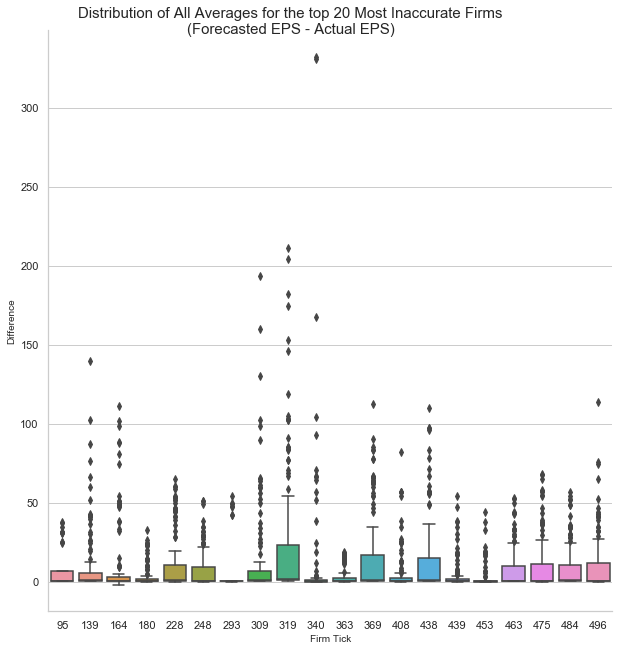

In [114]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [7, 7])

g = sb.catplot(x = 'firm_id', y = 'average', data = df_avgs_bottom_ticks, kind = "box")

plt.suptitle('Distribution of All Averages for the top 20 Most Inaccurate Firms\n(Forecasted EPS - Actual EPS)', size = 15)
# plt.title('(Forecasted EPS - Actual EPS)')
g.fig.set_size_inches(10,10)
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-raw-bottom.png')

In [115]:
#convert differences to absolute value
all_diffs.difference = all_diffs.difference.abs()

In [116]:
#isolate all_diffs by ticks
df_diffs_top_ticks = all_diffs[all_diffs['firm_id'].isin(all_diffs_top.firm_id.values)]
df_diffs_bottom_ticks = all_diffs[all_diffs['firm_id'].isin(all_diffs_bottom.firm_id.values)]

<Figure size 360x360 with 0 Axes>

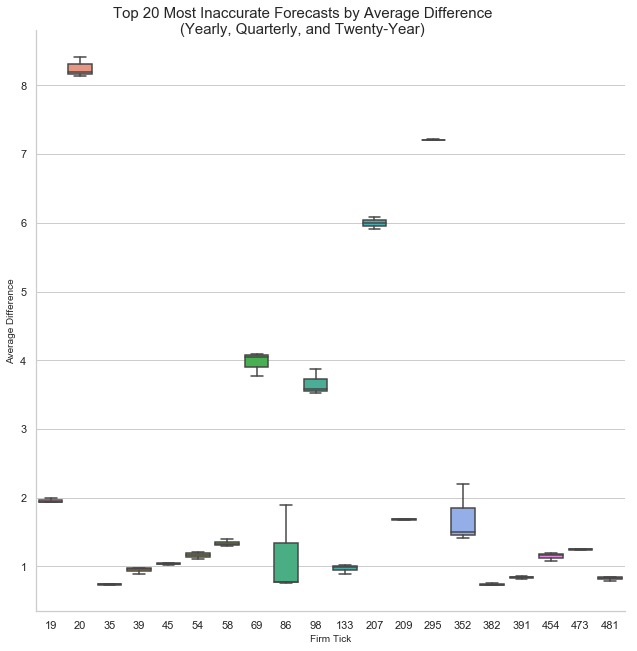

In [117]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [5, 5])

g = sb.catplot(x = 'firm_id', y = 'difference', data = df_diffs_top_ticks, kind = "box")

plt.suptitle('Top 20 Most Inaccurate Forecasts by Average Difference\n(Yearly, Quarterly, and Twenty-Year)', size = 15)
# plt.title('(Forecasted EPS - Actual EPS)')
g.fig.set_size_inches(10,10)
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Average Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-diffs-top.png')

<Figure size 360x360 with 0 Axes>

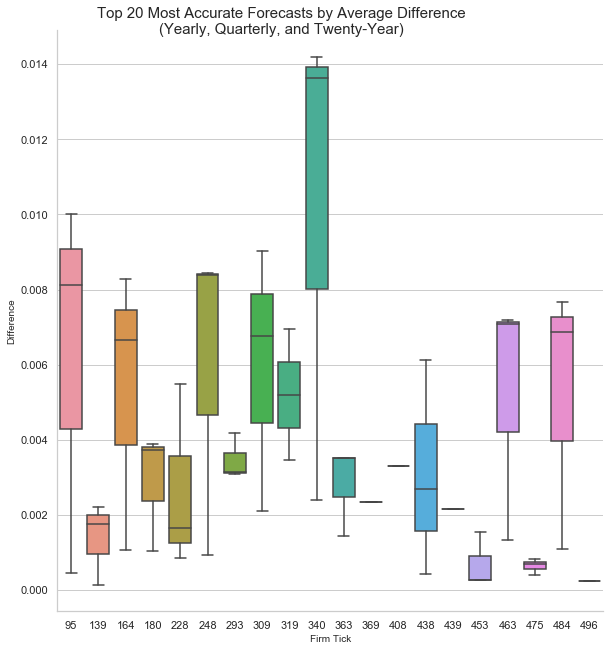

In [118]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [5, 5])

g = sb.catplot(x = 'firm_id', y = 'difference', data = df_diffs_bottom_ticks, kind = "box")

plt.suptitle('Top 20 Most Accurate Forecasts by Average Difference\n(Yearly, Quarterly, and Twenty-Year)', size = 15)
# plt.title('(Forecasted EPS - Actual EPS)')
g.fig.set_size_inches(10,10)
plt.xlabel('Firm Tick', size = 10)
plt.ylabel('Difference', size = 10)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-diffs-bottom.png')
plt.show();

### Linear Regression Test for all EPS_ACT AVERAGES  vs. EPS_FC AVERAGES

> Considering that it's impossible to visually conclude a skew or distribution from the graphics alone, can we implement linear regression tests to verify that the relationship between forecasted and actual EPS is statistically significant?



For all linear regression tests, I will ***use the non-absolute values*** of the differences. This is because using a linear regression model on raw, unfiltered data will give more precise results.

H0: The higher the forecasted value, the higher the actual value.

H1: The higher the forecasted value, the lower or equal the actual value.

In [119]:
def implement_ols(df, y, x, avg_type):
    lm = sm.OLS(df[y], df[['intercept', x]], missing = 'drop')
    result = lm.fit()
    
    p_val = result.pvalues[x]
    coeff = result.params[x]
    r = math.sqrt(result.rsquared)
    
    return (result.summary(), p_val, coeff, r)
#     return (statement.format(avg_type, p_val, coeff, r))

**Isolate Twenty-Year EPS data by firm to fit OLS model**

In [120]:
#helper function to separate eps_act and eps_fc averages into their own columns
def separate_eps_fc_act(df, groupby_arr, value_col):
    #combine eps_fc and eps_act averages into a single column, joined on firm id and time period
    df1 = df.groupby(groupby_arr)[value_col].apply(lambda x: ', '.join(x.astype(str))).reset_index()
    
    #separate eps_fc and eps_act averages then rename columns
    df1 = pd.concat([df1[groupby_arr], df1[value_col].str.split(', ', expand = True)], axis = 1)
    df1.rename(columns = {0: 'eps_fc', 1: 'eps_act'}, inplace = True)
    
    #convert data types
    df1 = df1.astype({'eps_fc' : 'float64', 'eps_act' : 'float64'})
    
    #add intercept
    df1['intercept'] = 1
    
    return df1

In [121]:
avgs_twenty_ols = separate_eps_fc_act(avgs_twenty, ['firm_id', 'average_type'], 'average')
avgs_twenty_ols.sample(10)

,firm_id,average_type,eps_fc,eps_act,intercept
83,83,twenty_year,1.868393,1.520366,1
69,69,twenty_year,9.167367,5.120181,1
270,270,twenty_year,0.695905,0.495466,1
449,449,twenty_year,0.095720,-0.060413,1
469,469,twenty_year,0.939905,0.968334,1
364,364,twenty_year,0.690274,0.691766,1
392,392,twenty_year,0.806345,0.820843,1
252,252,twenty_year,0.800731,0.823922,1
109,109,twenty_year,0.258137,0.221558,1
496,496,twenty_year,0.372024,0.372262,1


**Isolate Quarterly EPS data by firm to fit OLS model**

In [122]:
avgs_quarter_ols = separate_eps_fc_act(avgs_quarter, ['firm_id', 'average_type', 'time_period'], 'average')
avgs_quarter_ols.sample(10)

,firm_id,average_type,time_period,eps_fc,eps_act,intercept
1770,442,quarterly,q3,0.383368,0.377562,1
1187,296,quarterly,q4,0.318286,0.391667,1
1509,377,quarterly,q2,1.410524,1.461429,1
1797,449,quarterly,q2,0.086667,0.072857,1
1052,263,quarterly,q1,0.363238,0.383810,1
1366,341,quarterly,q3,0.085952,0.031429,1
1600,400,quarterly,q1,0.336952,0.295504,1
683,170,quarterly,q4,0.808429,0.784000,1
1940,485,quarterly,q1,1.610714,1.428095,1
103,25,quarterly,q4,0.694381,0.666499,1


**Isolate Yearly EPS data by firm to fit OLS model**

In [123]:
avgs_year_ols = separate_eps_fc_act(avgs_year, ['firm_id', 'average_type', 'time_period'], 'average')
avgs_year_ols.sample(10)

,firm_id,average_type,time_period,eps_fc,eps_act,intercept
4447,211,yearly,2015,0.57925,0.51875,1
2279,108,yearly,2010,0.32000,0.35250,1
7245,345,yearly,1999,0.03100,-0.01250,1
4858,231,yearly,2006,0.57850,0.60625,1
5582,265,yearly,2016,0.50000,0.39500,1
1494,71,yearly,2002,0.49575,0.51500,1
6248,297,yearly,2010,0.18200,0.15000,1
1414,67,yearly,2006,0.50775,0.16000,1
778,37,yearly,2000,NaN,NaN,1
7558,359,yearly,2018,0.73750,0.22000,1


**Isolate Raw EPS data by firm to fit OLS model**

In [684]:
features_eps_fc_act = features.loc[features['feature'].isin(['eps_act', 'eps_fc'])]
features_all_ols = separate_eps_fc_act(features_eps_fc_act, ['firm_id', 'term'], 'value')
features_all_ols.sample(10)

,firm_id,term,eps_fc,eps_act,intercept
14589,173,2013Q2,0.383,0.415,1
15202,180,2019Q3,0.355,0.370,1
31361,373,2006Q2,0.229,0.310,1
33312,396,2011Q1,-0.097,0.010,1
40355,480,2007Q4,1.592,1.390,1
22774,271,2001Q3,NaN,NaN,1
7097,84,2009Q2,NaN,0.310,1
20277,241,2007Q2,0.152,0.156,1
35967,428,2002Q4,NaN,NaN,1
14021,166,2018Q2,0.313,0.310,1


In [173]:
statement = 'Actual EPS vs Forecasted EPS ({}):\np-value: {:.5f}\ncoefficient: {:.5f}\nr-value: {:.5f}\n'

twenty_ols = implement_ols(avgs_twenty_ols, 'eps_act', 'eps_fc', 'Twenty-Year')
quarter_ols = implement_ols(avgs_quarter_ols, 'eps_act', 'eps_fc', 'Quarterly')
year_ols = implement_ols(avgs_year_ols, 'eps_act', 'eps_fc', 'Yearly')
all_ols = implement_ols(features_all_ols, 'eps_act', 'eps_fc', 'All')

In [174]:
#put all ols in an array
ols = [twenty_ols, quarter_ols, year_ols, all_ols]

In [175]:
#display brief summary for each


**Observation 1:** The coefficient associated with `average_eps_fc` is 0.8680. This depicts a ***strong positive linear relationship*** between the forecasted and actual twenty-year EPS averages.

**Observation 2:** Let's establish our Type I error rate to be 0.05. The calculated p-value for `average_eps_fc` is 0.00. Since the p-value is less than our error threshold, ***the relationship between the twenty-year forecasted and actual EPS averages is statistically significant.***
> This is evidence in favor of my alternative hypothesis, therefore we ***accept the null hypothesis*** that as the value for forecasted twenty-year average EPS increases, the higher the actual value.



### EPS_FC vs. EPS_ACT Scatterplots

> Check if the scatterplots are consistent with the results from their linear regression models.

**Twenty-Year**

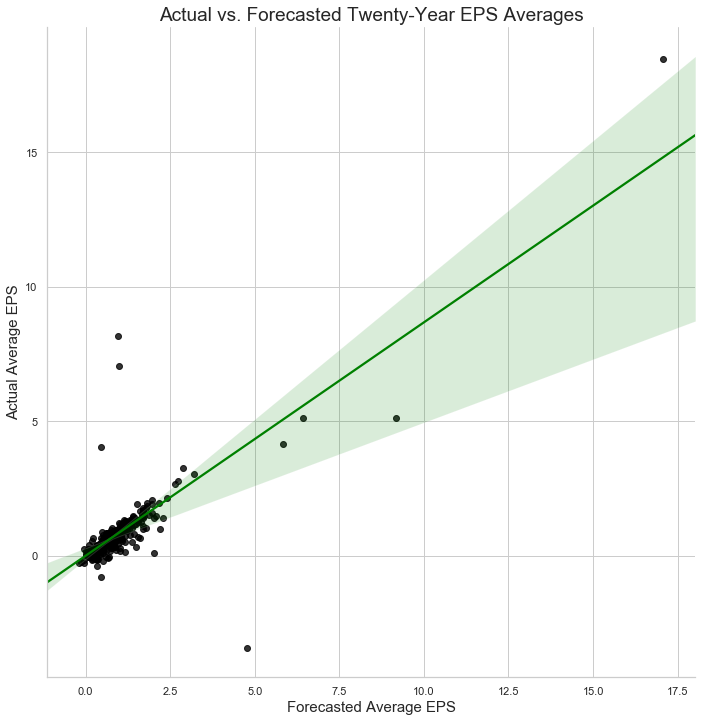

In [128]:
sb.lmplot(data= avgs_twenty_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'green'})
plt.title('Actual vs. Forecasted Twenty-Year EPS Averages', size = 19)
plt.xlabel('Forecasted Average EPS', size = 15)
plt.ylabel('Actual Average EPS', size = 15)
plt.savefig(PATH_BIVARIATE + 'eps_fc_act_twenty_year.png')

**Quarterly**

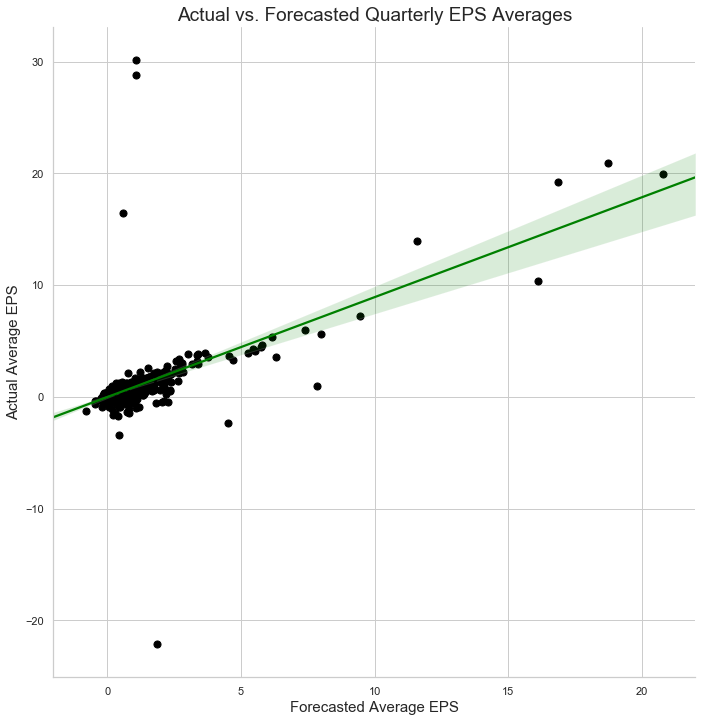

In [129]:
sb.lmplot(data= avgs_quarter_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'green'}, x_estimator = np.mean)
plt.title('Actual vs. Forecasted Quarterly EPS Averages', size = 19)
plt.xlabel('Forecasted Average EPS', size = 15)
plt.ylabel('Actual Average EPS', size = 15)
plt.savefig(PATH_BIVARIATE + 'eps_fc_act_quarter.png')

**Yearly**

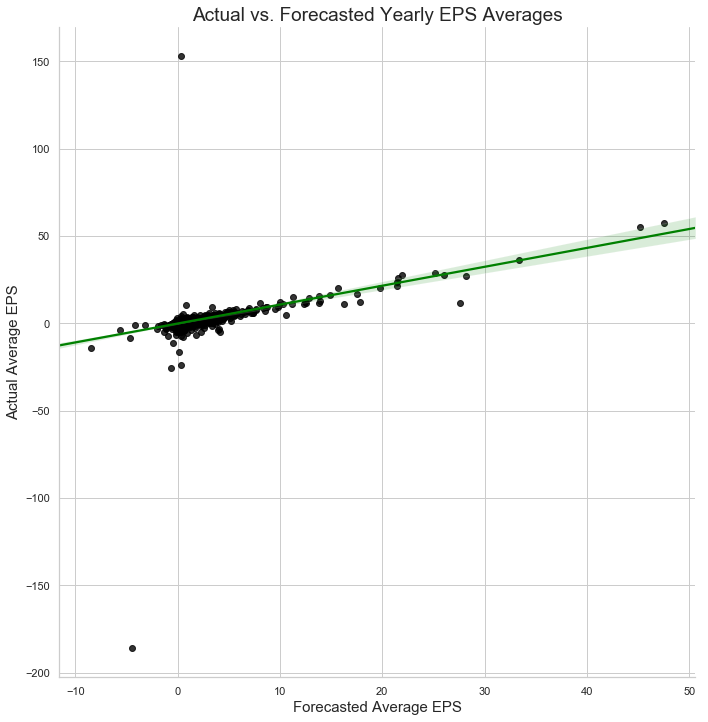

In [130]:
sb.lmplot(data= avgs_year_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'green'})
plt.title('Actual vs. Forecasted Yearly EPS Averages', size = 19)
plt.xlabel('Forecasted Average EPS', size = 15)
plt.ylabel('Actual Average EPS', size = 15)
plt.savefig(PATH_BIVARIATE + 'eps_fc_act_year.png')

**All**

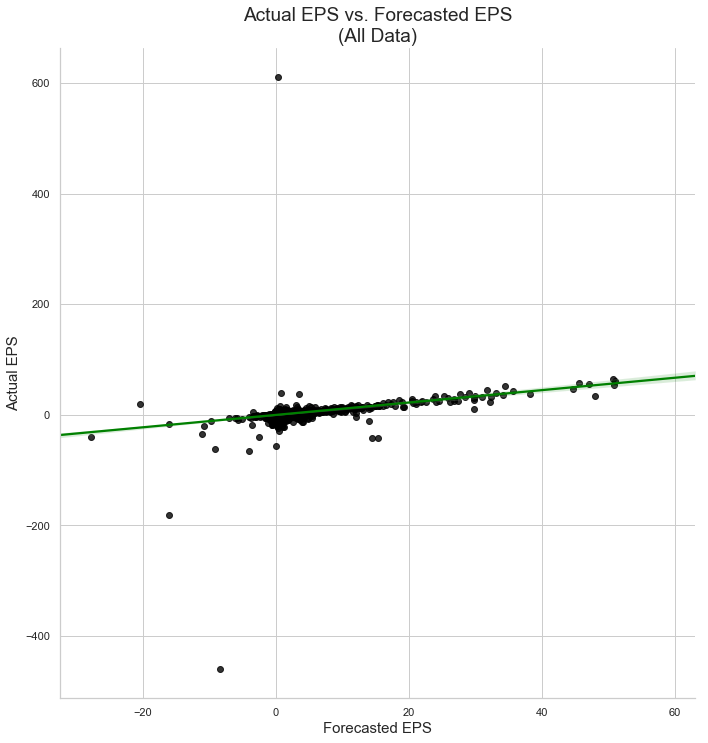

In [131]:
sb.lmplot(data= features_all_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'green'})
plt.title('Actual EPS vs. Forecasted EPS\n(All Data)', size = 19)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)
plt.savefig(PATH_BIVARIATE + 'eps_fc_act_all.png')

In [225]:
all_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5115.
Date:                Sat, 18 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:05:18   Log-Likelihood:                -99603.
No. Observations:               34448   AIC:                         1.992e+05
Df Residuals:                   34446   BIC:                         1.992e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1697      0.027     -6.399      0.000      -0.222      -0.118
eps_fc         1.1196      0.016     71.516      0.000       1.089       1.150
==============================================================================
Omnibus:                   106243.709   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     299298412516.719
Skew:                          45.670   Prob(JB):                         0.00
Kurtosis:                   14442.998   Cond. No.                         2.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation 1:** Interestingly enough, the graph encompassing the broadest data (all data from features) has the ***most stable 95% confidence interval*** as per the regression line.

**Observation 2:** The quarterly average regression line is the most unstable.

### "Dumb Predictions" vs "Expert Predictions"

1) Create a DF depicting `eps_act` last quarter vs `eps_act` this quarter.

2) Create "dumb predictions" 

3) Compare my predictions to all `eps_fc` values 

In [972]:
#isolate eps_act entries, drop date column
features_dumb_eps = features[features['feature'] == 'eps_act'].loc[:, features.columns != 'date']

In [973]:
features_dumb_eps.head()

,firm_id,feature,term,value
125240,0,eps_act,1999Q1,0.16
125241,0,eps_act,1999Q2,0.35
125242,0,eps_act,1999Q3,0.30
125243,0,eps_act,1999Q4,0.32
125244,0,eps_act,2000Q1,0.29


In [974]:
#grab previous eps_act term
features_dumb_eps['previous_value'] = features_dumb_eps['value'].shift(1)

In [975]:
#create dumb prediction
features_dumb_eps['dumb_prediction'] = features_dumb_eps[['value', 'previous_value']].mean(axis = 1)

In [976]:
#preview
features_dumb_eps.sample(5)

,firm_id,feature,term,value,previous_value,dumb_prediction
125916,8,eps_act,2000Q1,NaN,NaN,NaN
158636,397,eps_act,2011Q1,0.18,0.17,0.175
127085,21,eps_act,2019Q2,0.40,1.88,1.140
153266,333,eps_act,2012Q3,0.19,0.30,0.245
149728,291,eps_act,2010Q1,1.43,2.19,1.810


In [977]:
features_fc_series.head()

,date,term,value
82820,NaT,1999Q1,NaN
82821,NaT,1999Q2,NaN
82822,NaT,1999Q3,NaN
82823,NaT,1999Q4,NaN
82824,NaT,2000Q1,NaN


In [978]:
temp = ~(features_fc.isna()['value']).lt(1).idxmax()

In [979]:
features.iloc[temp]

firm_id        23
feature    eps_fc
date          NaT
term       2014Q3
value       0.676
Name: 84814, dtype: object

In [980]:
#create column showing corresponding eps_fc for that term

#create Series of eps_fc values
features_fc = features[features.feature == 'eps_fc'].drop(columns = ['date', 'feature'])

In [981]:
#merge eps_fc values with dumb predictions on 'firm_id' and 'term'
features_dumb_eps = features_dumb_eps.merge(features_fc, on = ['term', 'firm_id'], how = 'left')
features_dumb_eps.rename(columns = {'value_x' : 'value', 'value_y' : 'eps_fc_value'}, inplace = True)

In [ ]:
features_dumb

### Paired Scatterplots


### Term vs. Features
6) Which features under Term does not contain the year 1999?

### ?
7) How do value counts under Features look like after removing all outliers around the value range 0-300?

## V) Multivariate Exploration <a id="multi"></a>

idea: introduce a polar chart

### Time vs. Percentage Error vs. Firm IDs

In [813]:
#add percentage_error column to features
features_pct = features[features.feature.isin(['eps_fc', 'eps_act'])]

In [814]:
features_pct = separate_eps_fc_act(features_pct, ['firm_id', 'term'], 'value')

In [815]:
features_pct['percentage_error'] = (features_pct.eps_fc - features_pct.eps_act) / features_pct.eps_act

In [816]:
features_pct['percentage_error'] = features_pct['percentage_error'].replace([np.inf, -np.inf], np.nan)

In [817]:
#get absolute value of percentage errors for magnitude
features_pct_abs = features_pct.copy()
features_pct_abs['percentage_error'] = features_pct_abs['percentage_error'].abs()

In [818]:
#rearrange by descending percentage error
features_pct_abs = features_pct_abs.sort_values(by = 'percentage_error', ascending = False)

In [819]:
#grab top 10 firms with biggest absolute percentage errors
top_ids = features_pct_abs.firm_id.drop_duplicates().values[:5]

In [820]:
#isolate top 10 firms and their non-absolute percentage_errors
features_top_ids = features_pct[features_pct.firm_id.isin(top_ids)]

In [821]:
#create dictionary of firm ids and firms
firm_ids_dict = firm_ids.set_index('firm_id').to_dict()['firm']

In [822]:
#helper function to convert legend firm ids to firm ticks
def convert_legend_to_ticks(ax):
    label_list = []
    for t in ax.get_legend_handles_labels():
        label_list.append(t)
    
    new_list = []
    
    for txt in label_list[1]:
        txt = np.vectorize(firm_ids_dict.get)(np.array(txt).astype(int))
        new_list.append(str(txt).upper())
        
    label_list[1] = new_list
    ax.legend(handles = label_list[0], labels = label_list[1])

> **Percentage Error by Year**

In [823]:
pct_error_means_year = features_top_ids.groupby(['firm_id', features_top_ids.term.dt.year]).mean().reset_index().rename(columns = {'percentage_error' : 'average_percentage_error'})

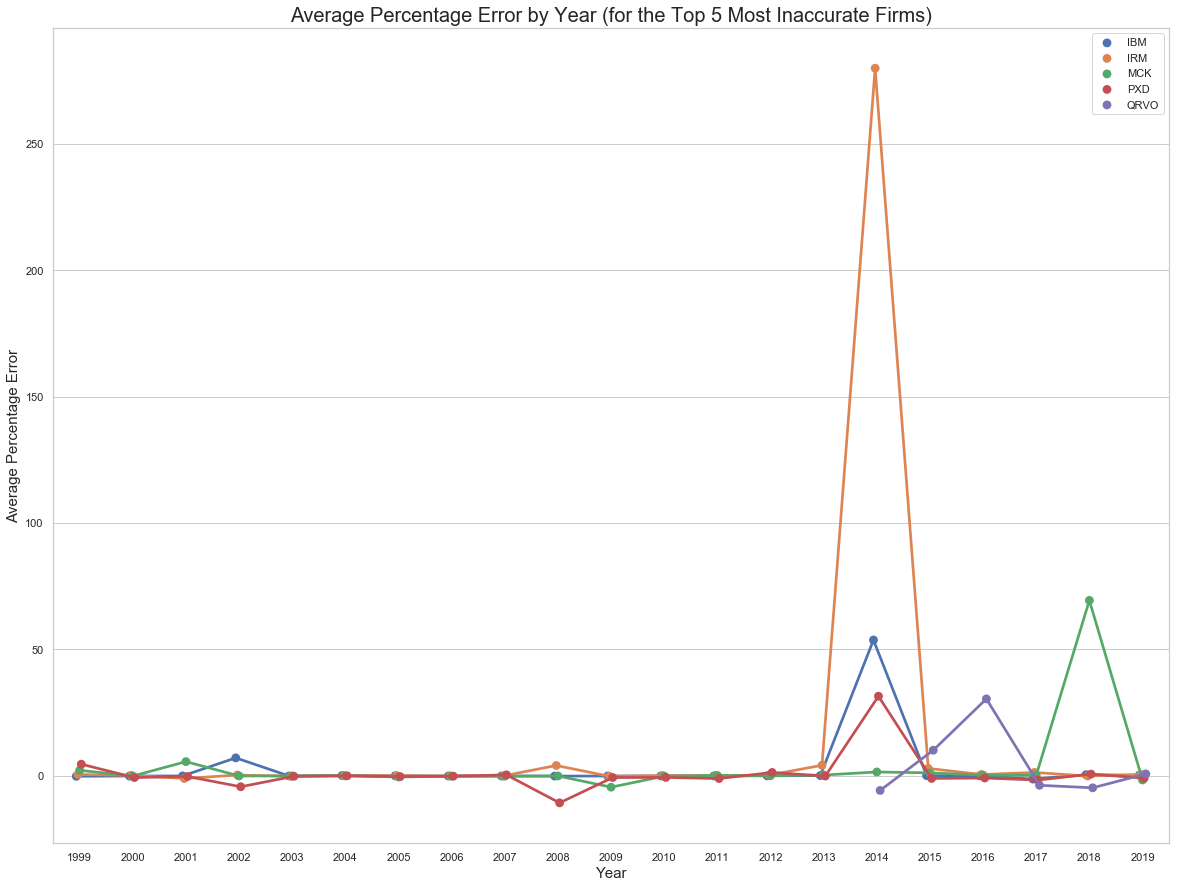

In [824]:
plt.figure(figsize = [20, 15])
ax = sb.pointplot(data = pct_error_means_year, x = pct_error_means_year.term, y = 'average_percentage_error', hue = 'firm_id', dodge = True,
                  legend_out = False)

#edit legend
convert_legend_to_ticks(ax)

plt.xlabel('Year')
plt.ylabel('Average Percentage Error')
plt.title('Average Percentage Error by Year (for the Top 5 Most Inaccurate Firms)', size = 20)

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-year.png')
plt.show()

> **Percentage Error by Quarter**

In [825]:
pct_error_means_quarter = features_top_ids.groupby(['firm_id', features_top_ids.term.dt.quarter]).mean().reset_index().rename(columns = {'percentage_error' : 'average_percentage_error'})

In [826]:
#cast quarter intervals as str
pct_error_means_quarter.term = pct_error_means_quarter.term.astype(str)

In [827]:
#add 'Q' before every quarter interval
pct_error_means_quarter = pct_error_means_quarter.assign(term = 'Q' + pct_error_means_quarter.term)

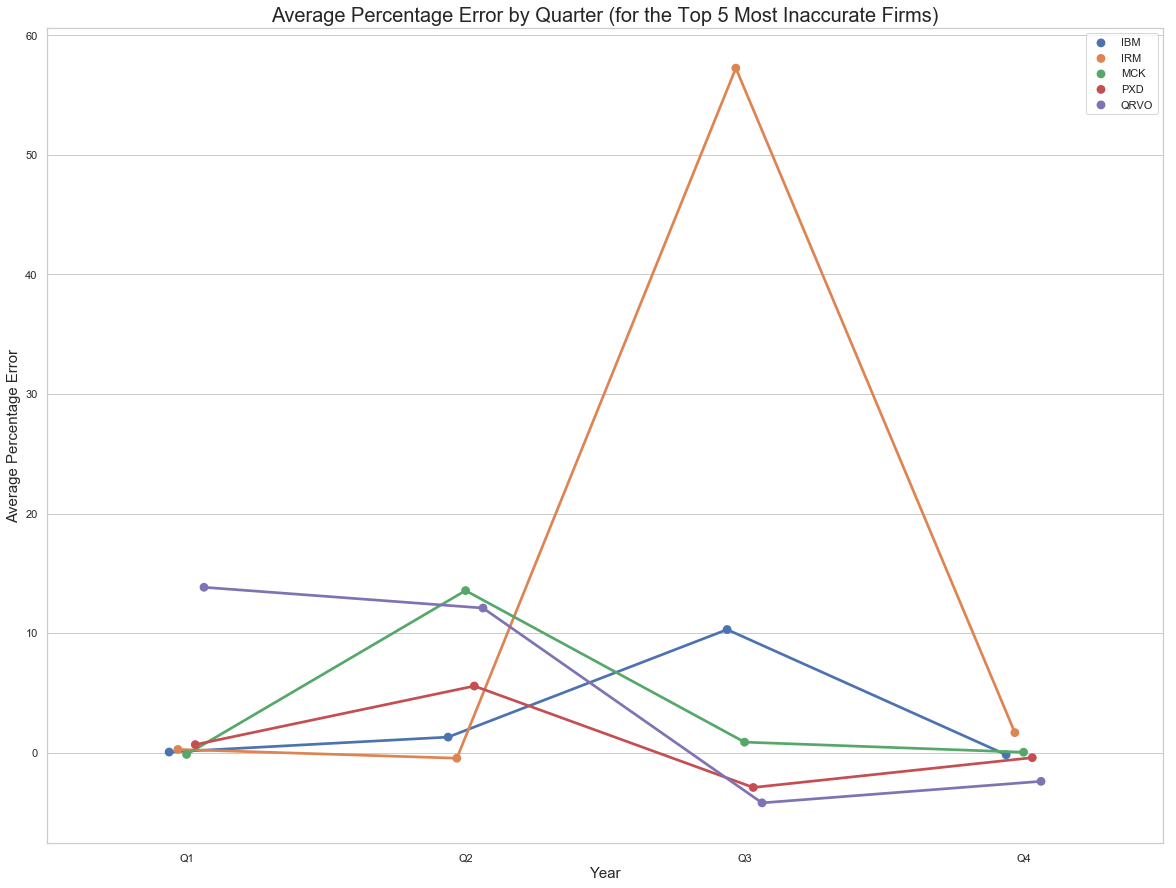

In [828]:
plt.figure(figsize = [20, 15])
ax = sb.pointplot(data = pct_error_means_quarter, x = pct_error_means_quarter.term, y = 'average_percentage_error', hue = 'firm_id', dodge = True,
                  legend_out = False)

#edit legend
convert_legend_to_ticks(ax)

plt.xlabel('Year')
plt.ylabel('Average Percentage Error')
plt.title('Average Percentage Error by Quarter (for the Top 5 Most Inaccurate Firms)', size = 20)

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-quarter.png')
plt.show()

> **Percentage Error by Year and Quarter**


In [829]:
#reorder terms
features_top_ids = features_top_ids.sort_values(by = 'term')

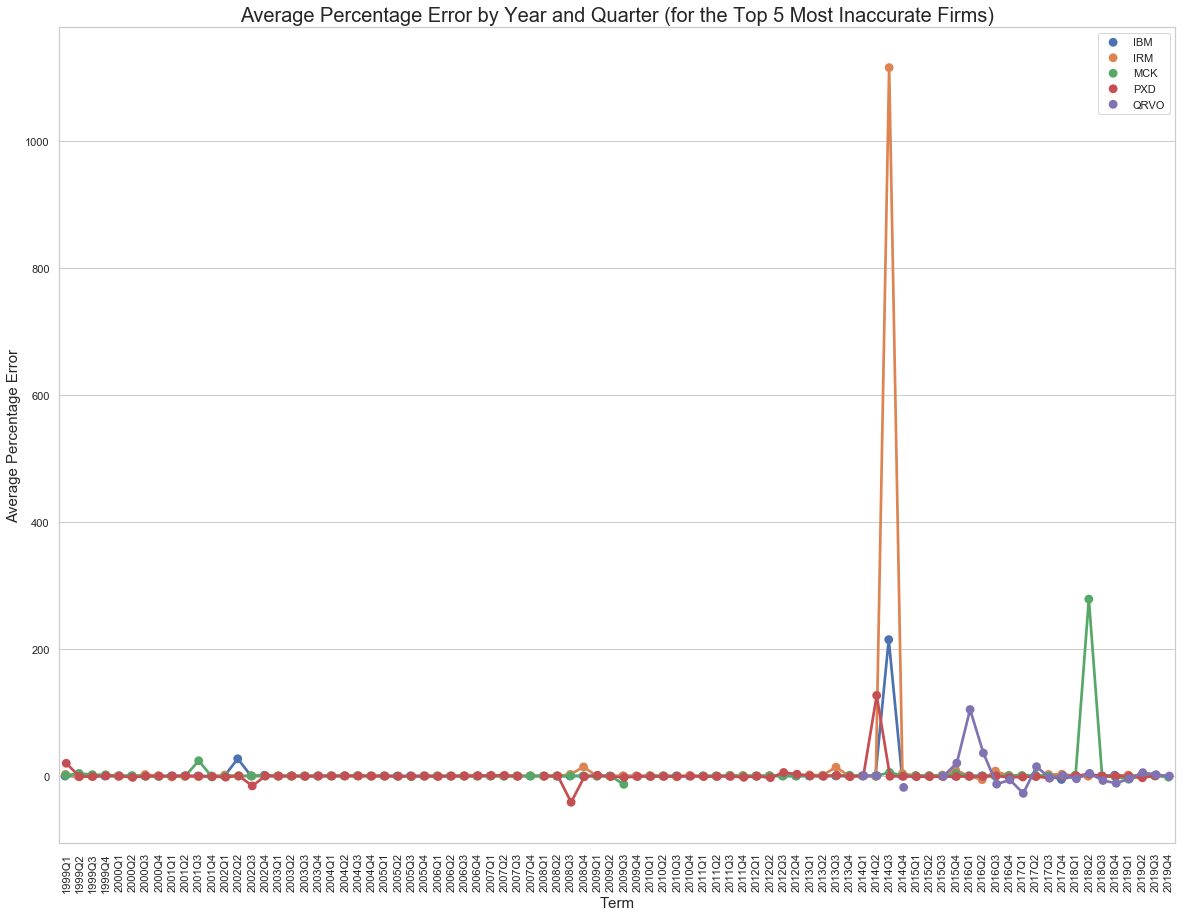

In [830]:
plt.figure(figsize = [20, 15])
ax = sb.pointplot(data = features_top_ids, x = features_top_ids.term, y = 'percentage_error', hue = 'firm_id', dodge = True,
                  legend_out = False)

#edit legend
convert_legend_to_ticks(ax)

plt.xlabel('Term')
plt.ylabel('Average Percentage Error')
plt.title('Average Percentage Error by Year and Quarter (for the Top 5 Most Inaccurate Firms)', size = 20)
plt.xticks(rotation = 'vertical')

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-term.png')
plt.show()

### Values by Feature by Term

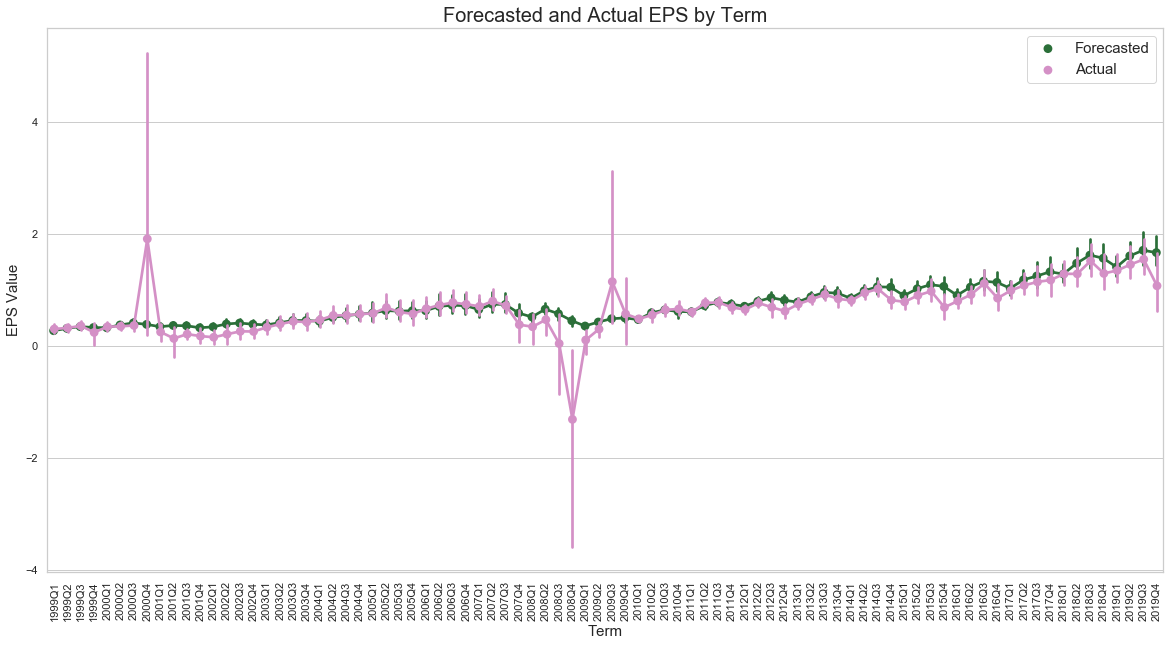

In [802]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(data = features[features.feature.isin(['eps_fc', 'eps_act'])], x = 'term', y = 'value',
                  hue = 'feature', dodge = True, legend_out = False, palette = "cubehelix")
plt.xticks(rotation = 'vertical')


plt.title('Forecasted and Actual EPS by Term', size = 20)
plt.ylabel('EPS Value')
plt.xlabel('Term')

#adjust legend
handles, labels = ax.get_legend_handles_labels()
labels = ['Forecasted', 'Actual']
ax.legend(handles, labels, prop = {'size' : 15})

plt.savefig(PATH_MULTIVARIATE + 'features-eps-by-term.png')
plt.show();